<h1><center>MARÍA VICTORIA SANTANA RODRÍGUEZ </center></h1>
<font color="darkblue">
<h3> <center>TFM</center> </h3>
<h3> <center>Julio-Agosto 2024</center> </h3>

<font color="darkblue"><h2> Previsión_PASAJEROS</h2> 

**Objetivo**: Hacer previsiones de los datos que se tiene de pasajeros.

In [1]:
# Se importan los paquetes y librerías necesarias
import pandas as pd
import os
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from pmdarima import auto_arima
import joblib
import re 
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

### A. Carga del fichero

Se carga el fichero que previamente ha sido limpiado y procesado

In [2]:
# Ruta en la que se encuentra el fichero
Ruta_Pasajeros_Unico = './Ficheros_unico/P_Unico.csv'

# Se carga el DataFrame desde el archivo CSV
Pasajeros_merge_pivotar = pd.read_csv(Ruta_Pasajeros_Unico, parse_dates=['Fecha'])

# Se comprueba que se carga correctamente
print(Pasajeros_merge_pivotar.head())

                Aeropuerto_Base             Tipo      Fecha    Valor
0                      A CORUÑA  P_Total_Llegada 2004-01-01    20189
1  ADOLFO SUÁREZ MADRID-BARAJAS  P_Total_Llegada 2004-01-01  1344245
2                      ALBACETE  P_Total_Llegada 2004-01-01      133
3   ALICANTE-ELCHE MIGUEL HDEZ.  P_Total_Llegada 2004-01-01   233342
4                       ALMERÍA  P_Total_Llegada 2004-01-01    22010


In [3]:
# Se modifica el nombre del fichero
Pasajeros_Unico = Pasajeros_merge_pivotar

# Se comprueba que tipo de dato hay en cada columna y que es correcto
print(Pasajeros_Unico.dtypes)

# Asegurarse de que la fecha sea el índice para el análisis de series temporales
Pasajeros_Unico.set_index('Fecha', inplace=True)

# Se comprueba que se carga correctamente
print(Pasajeros_Unico.head())

Aeropuerto_Base            object
Tipo                       object
Fecha              datetime64[ns]
Valor                       int64
dtype: object
                         Aeropuerto_Base             Tipo    Valor
Fecha                                                             
2004-01-01                      A CORUÑA  P_Total_Llegada    20189
2004-01-01  ADOLFO SUÁREZ MADRID-BARAJAS  P_Total_Llegada  1344245
2004-01-01                      ALBACETE  P_Total_Llegada      133
2004-01-01   ALICANTE-ELCHE MIGUEL HDEZ.  P_Total_Llegada   233342
2004-01-01                       ALMERÍA  P_Total_Llegada    22010


### B. Predicciones

En este apartado se trata de hacer las predicciones de los datos estudiados, para ello se van a probar distintos modelos hasta encontrar el que mejores resultados arroje. No se van a usar tantos modelos como en para los ficheros de operaciones.

In [4]:
import warnings
warnings.filterwarnings("ignore")

**1. Modelo ARIMA**

Se prueba un modelo Arima, con unos parámetros aleatorios, muy básicos de (1,1,1) para ver que resultados se obtienen, y partir de esta base. 

In [5]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Pasajeros = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Pasajeros_Unico['Aeropuerto_Base'].unique()
Tipos_Pasajeros = Pasajeros_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Pasajero in Tipos_Pasajeros:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Pasajeros = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Pasajeros_Unico['Tipo'] == Pasajero)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Pasajeros = Datos_Reales_Pasajeros.sort_index()
        Datos_Reales_Pasajeros = Datos_Reales_Pasajeros.asfreq('MS')
        
        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima = ARIMA(Datos_Reales_Pasajeros['Valor'], order=(1, 1, 1))
            model_fit_arima = model_arima.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales = model_fit_arima.predict(start=Datos_Reales_Pasajeros.index[0], end=Datos_Reales_Pasajeros.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras = model_fit_arima.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Pasajeros[(Aeropuerto, Pasajero)] = (Predicciones_Originales, Predicciones_Futuras, Datos_Reales_Pasajeros.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Pasajero}: {e}")

**1-a. Almacenar las predicciones**

In [6]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Pasajeros = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales, Predicciones_Futuras, Fechas_Reales) in Dicc_Predicciones_Pasajeros.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Predicciones_Originales = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras), freq='MS')
    Predicciones_Futuras = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Pasajeros = pd.concat([Predicciones_Pasajeros, Predicciones_Originales, Predicciones_Futuras], ignore_index=True)

In [7]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales, Predicciones_Futuras, Fechas_Reales) in Dicc_Predicciones_Pasajeros.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Valor Real': Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor'],
        'Prediccion': Predicciones_Originales
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras), freq='MS')
    Temp_Predicciones_Futuras = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras),
        'Prediccion': Predicciones_Futuras
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos = pd.concat([Comparacion_Total_Todos_Aeropuertos, Tem_Predicciones_Historicas, Temp_Predicciones_Futuras], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real   Prediccion
50548  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01       1597  2442.427901
50549  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01       2942  1437.172559
50550  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01       3256  3459.397951
50551  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01       2719  3105.411834
50552  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01       3482  2617.315519
50553  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01       3413  3780.902325
50554  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01       3715  3244.237700
50555  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01       7120  3896.180093
50556  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01       None  8143.256297
50557  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01       None  7976.795375
50558  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01       None  8003.874845
50559  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01       None

In [9]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos['Valor Real'] = Comparacion_Total_Todos_Aeropuertos['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos['Prediccion'] = Comparacion_Total_Todos_Aeropuertos['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos['Valor Real'] = Comparacion_Total_Todos_Aeropuertos['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos['Prediccion'] = Comparacion_Total_Todos_Aeropuertos['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01    1597,00    2442,43
50549  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01    2942,00    1437,17
50550  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01    3256,00    3459,40
50551  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01    2719,00    3105,41
50552  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01    3482,00    2617,32
50553  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01    3413,00    3780,90
50554  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01    3715,00    3244,24
50555  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01    7120,00    3896,18
50556  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01               8143,26
50557  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01               7976,80
50558  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01               8003,87
50559  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01               7999,47
50560  MURCI

**1-b. Visualizar predicciones**

**Pasajeros de llegada**, se visualizan las predicciones para un aeropuerto en particular que se guardan en un mismo dataframe, los datos reales con las predicciones de los rangos de fecha de los datos que se tienen junto con un periodo de 12 meses adicionales

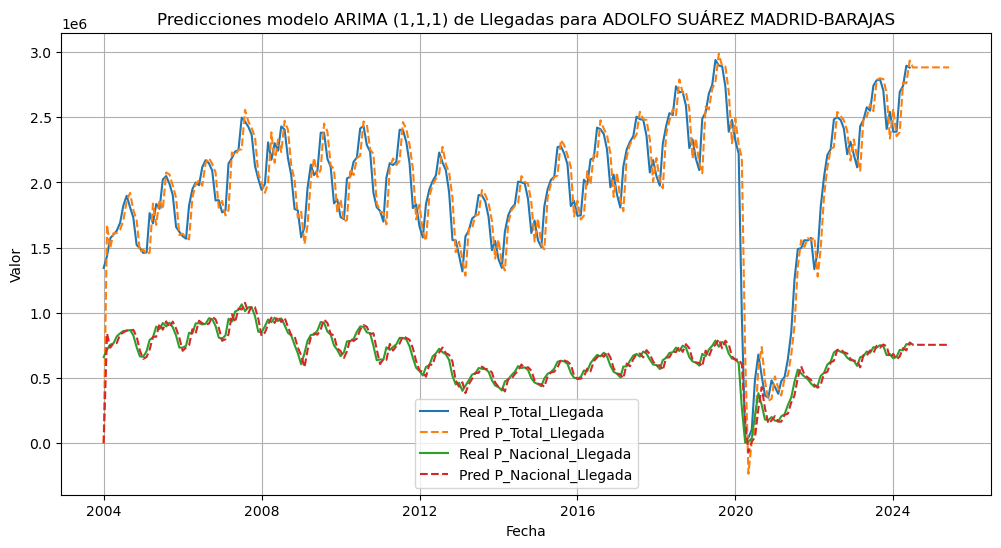

In [10]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajeros = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Pasajeros if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajero_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajeros = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajeros = Predicciones_Pasajeros[(Predicciones_Pasajeros['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajeros['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajeros.index, Datos_Reales_Pasajeros['Valor'], label=f'Real {Tipo_Pasajero_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajeros['Fecha'], Datos_Predicciones_Pasajeros['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajero_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo ARIMA (1,1,1) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**Pasajeros de salida**, se visualizan las predicciones, para un aeropuerto en particular que se guardan en un mismo dataframe, los datos reales con las predicciones de los rangos de fecha de los datos que se tienen junto con un periodo de 12 meses adicionales.

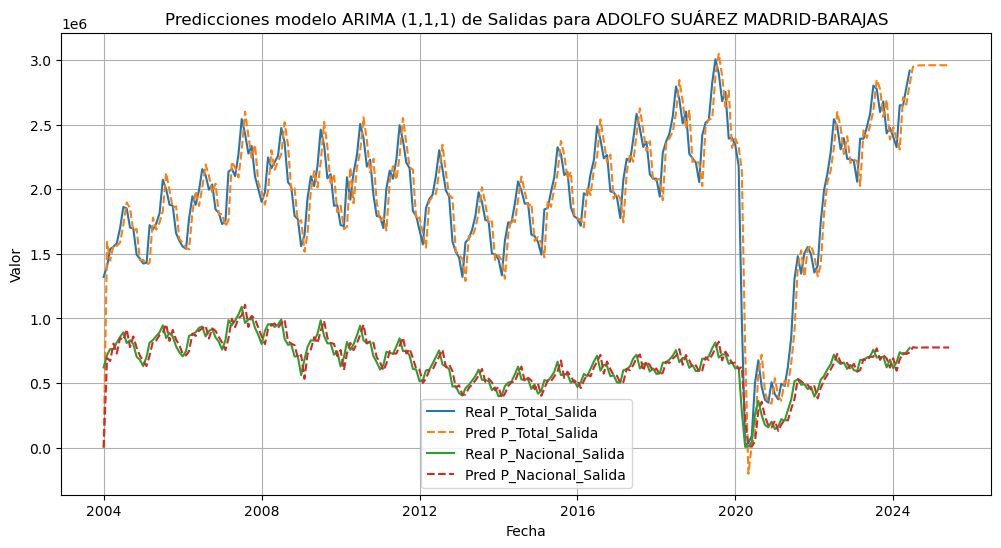

In [11]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajeros = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Salida = [tipo for tipo in Tipos_Pasajeros if 'Salida' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajero_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajeros = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajeros = Predicciones_Pasajeros[(Predicciones_Pasajeros['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajeros['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajeros.index, Datos_Reales_Pasajeros['Valor'], label=f'Real {Tipo_Pasajero_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajeros['Fecha'], Datos_Predicciones_Pasajeros['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajero_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo ARIMA (1,1,1) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**1-c. Métricas de Error**

In [76]:
# Función para calcular SMAPE
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Se añade la métrica SMAPE
Metricas_Error_Pasajeros = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Pasajero), (Predicciones_Historicas, _, Fechas_Reales) in Dicc_Predicciones_Pasajeros.items():
    # Se obtienen los valores reales
    Valores_Reales_Pasajeros = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Pasajeros) == len(Predicciones_Historicas):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Pasajeros, Predicciones_Historicas)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Pasajeros, Predicciones_Historicas))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Pasajeros - Predicciones_Historicas) / np.where(Valores_Reales_Pasajeros == 0, 1, Valores_Reales_Pasajeros))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Pasajeros, Predicciones_Historicas)
        
        Temp_Metricas_Error = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Pasajero],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Pasajeros = pd.concat([Metricas_Error_Pasajeros, Temp_Metricas_Error], ignore_index=True)

    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Pasajero}")

# Se muestran las métricas
print(Metricas_Error_Pasajeros)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     P_Total_Llegada    4346.379417   
1                        A CORUÑA  P_Nacional_Llegada    4070.644971   
2                        A CORUÑA      P_Total_Salida    3460.973653   
3                        A CORUÑA   P_Nacional_Salida    3254.618839   
4    ADOLFO SUÁREZ MADRID-BARAJAS     P_Total_Llegada  132634.944119   
..                            ...                 ...            ...   
191                     SON BONET   P_Nacional_Salida      52.592352   
192              MURCIA COMBINADO     P_Total_Llegada    9942.860400   
193              MURCIA COMBINADO  P_Nacional_Llegada     657.702961   
194              MURCIA COMBINADO      P_Total_Salida    9432.367980   
195              MURCIA COMBINADO   P_Nacional_Salida     628.368140   

              RMSE        MAPE      SMAPE  
0      5802.435600   55.644114  14.204498  
1      5287.777176   58.936904  14.202772  
2  

Se calculan los datos promedios de los errores para así, tener una visión de conjunto

In [14]:
# Se calculan las métricas medias para este modelo 
MAE_promedio = Metricas_Error_Pasajeros['MAE'].mean()
RMSE_promedio = Metricas_Error_Pasajeros['RMSE'].mean()
MAPE_promedio= Metricas_Error_Pasajeros['MAPE'].mean()
SMAPE_promedio = Metricas_Error_Pasajeros['SMAPE'].mean()

# Se muestran los resultados ARIMA (1,1,1)
print(f"MAE Promedio ARIMA (1,1,1): {MAE_promedio}")
print(f"RMSE Promedio ARIMA (1,1,1): {RMSE_promedio}")
print(f"MAPE Promedio ARIMA (1,1,1): {MAPE_promedio}%")
print(f"SMAPE Promedio ARIMA (1,1,1): {SMAPE_promedio}%")

MAE Promedio ARIMA (1,1,1): 13782.929607560378
RMSE Promedio ARIMA (1,1,1): 18946.924300805615
MAPE Promedio ARIMA (1,1,1): 274.71583052691733%
SMAPE Promedio ARIMA (1,1,1): 29.84379386629407%


Como se pueden ver en los valores promedio: 

- MAE Promedio ARIMA (1,1,1): 13782.929607560378- 
RMSE Promedio ARIMA (1,1,1): 18946.92430080561
- MAPE Promedio ARIMA (1,1,1): 274.71583052691733%- 
SMAPE Promedio ARIMA (1,1,1): 29.84379386629407
%
Los valores son muy alto para MAE y RSME, lo que indica que las predicciones y la precisión del modelo no es buena, como el RMSE es mayor que el MAE indica que hay grandes errores de predicción, se siguen buscando otros modelos 5

**2. Modelo Grid Search - ARIMA - 1 intento**

El segundo modelo es usar un Grid Search, para optimizar los hiperparámetros del modelo anterior, en teoría deberían de mejorar los resultados, ya que se están buscando los mejores para este conjunto de datos, y que así ofrezca un mejor rendimiento del mismo.

In [15]:
# Se definen los parámetros p, d, q
p = d = q = range(0, 4)  # Esto probará valores de 0 a 3 para p, d, q
pdq = list(itertools.product(p, d, q))

# Se almcenan los mejores resultados
best_aic = float('inf')
best_params = None

# Se itera sobre cada combinación de parámetros
for params in pdq:
    try:
        # Se entrena el modelo ARIMA con los parámetros actuales
        model_arima = ARIMA(Datos_Reales_Pasajeros['Valor'], order=params)
        model_fit_arima = model_arima.fit()
        
        # Se calcular el AIC
        aic = model_fit_arima.aic
        
        # Si el AIC actual es mejor que el anterior, actualizar los mejores parámetros
        if aic < best_aic:
            best_aic = aic
            best_params = params
            
    except Exception as e:
        print(f"Error con los parámetros {params}: {e}")
        continue

print(f'Mejor conjunto de parámetros: {best_params} con AIC: {best_aic}')

Mejor conjunto de parámetros: (3, 1, 2) con AIC: 6114.632356748734


El mejor conjunto de parámetros con Grind Search que se obtiene para los datos de operaciones es el (3, 1, 2)

- p (componente autorregresivo)=3
- d (componente integrado) =1
- q (media móvil) =2

**2-a. Se reentrena el modelo con los parámetros obtenidos, Modelo Grid Search - ARIMA - 1 intento**

In [16]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Pasajeros_GS = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Pasajeros_Unico['Aeropuerto_Base'].unique()
Tipos_Pasajeros = Pasajeros_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Pasajero in Tipos_Pasajeros:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Pasajeros_GS = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Pasajeros_Unico['Tipo'] == Pasajero)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Pasajeros_GS = Datos_Reales_Pasajeros_GS.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_GS = ARIMA(Datos_Reales_Pasajeros_GS['Valor'], order=(3, 1, 2))
            model_fit_arima_GS = model_arima_GS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_GS = model_fit_arima_GS.predict(start=Datos_Reales_Pasajeros_GS.index[0], end=Datos_Reales_Pasajeros_GS.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_GS = model_fit_arima_GS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Pasajeros_GS[(Aeropuerto, Pasajero)] = (Predicciones_Originales_GS, Predicciones_Futuras_GS, Datos_Reales_Pasajeros_GS.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Pasajero}: {e}")

**2-b. Dataframe en el que se guardan las predicciones y los datos reales**

In [17]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_GS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_GS, Predicciones_Futuras_GS, Fechas_Reales) in Dicc_Predicciones_Pasajeros_GS.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Valor Real': Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor'],
        'Prediccion': Predicciones_Originales_GS
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS), freq='MS')
    Temp_Predicciones_Futuras_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_GS),
        'Prediccion': Predicciones_Futuras_GS
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_GS = pd.concat([Comparacion_Total_Todos_Aeropuertos_GS, Tem_Predicciones_Historicas_GS, Temp_Predicciones_Futuras_GS], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_GS.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real   Prediccion
50548  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01       1597  2244.604024
50549  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01       2942  1875.126597
50550  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01       3256  3986.492084
50551  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01       2719  3446.062727
50552  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01       3482  2775.222871
50553  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01       3413  3918.584384
50554  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01       3715  3338.915815
50555  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01       7120  3831.375723
50556  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01       None  7651.365145
50557  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01       None  6509.162816
50558  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01       None  5374.206555
50559  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01       None

In [18]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_GS['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GS['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_GS['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_GS['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GS['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_GS['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_GS.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01    1597,00    2244,60
50549  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01    2942,00    1875,13
50550  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01    3256,00    3986,49
50551  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01    2719,00    3446,06
50552  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01    3482,00    2775,22
50553  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01    3413,00    3918,58
50554  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01    3715,00    3338,92
50555  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01    7120,00    3831,38
50556  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01               7651,37
50557  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01               6509,16
50558  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01               5374,21
50559  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01               4726,16
50560  MURCI

**2-c. Visualización de las predicciones** 

In [19]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Pasajeros_GS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_GS, Predicciones_Futuras_GS, Fechas_Reales) in Dicc_Predicciones_Pasajeros_GS.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_GS
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS), freq='MS')
    Temp_Predicciones_Futuras_GS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_GS
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Pasajeros_GS = pd.concat([Predicciones_Pasajeros_GS, Tem_Predicciones_Historicas_GS, Temp_Predicciones_Futuras_GS], ignore_index=True)

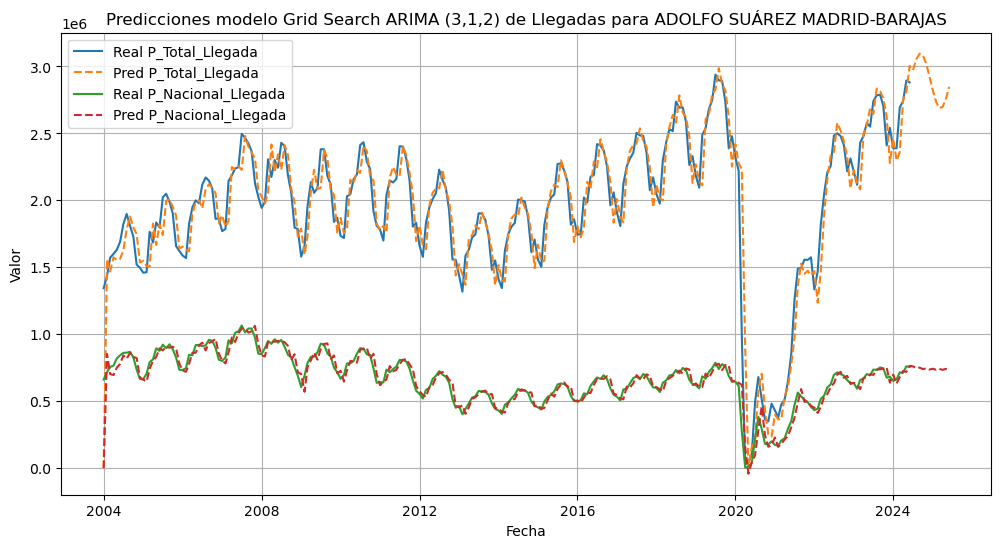

In [20]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajeros = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Pasajeros if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajeros_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajeros_GS = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajeros_GS = Predicciones_Pasajeros_GS[(Predicciones_Pasajeros_GS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajeros_GS['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajeros_GS.index, Datos_Reales_Pasajeros_GS['Valor'], label=f'Real {Tipo_Pasajeros_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajeros_GS['Fecha'], Datos_Predicciones_Pasajeros_GS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajeros_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (3,1,2) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

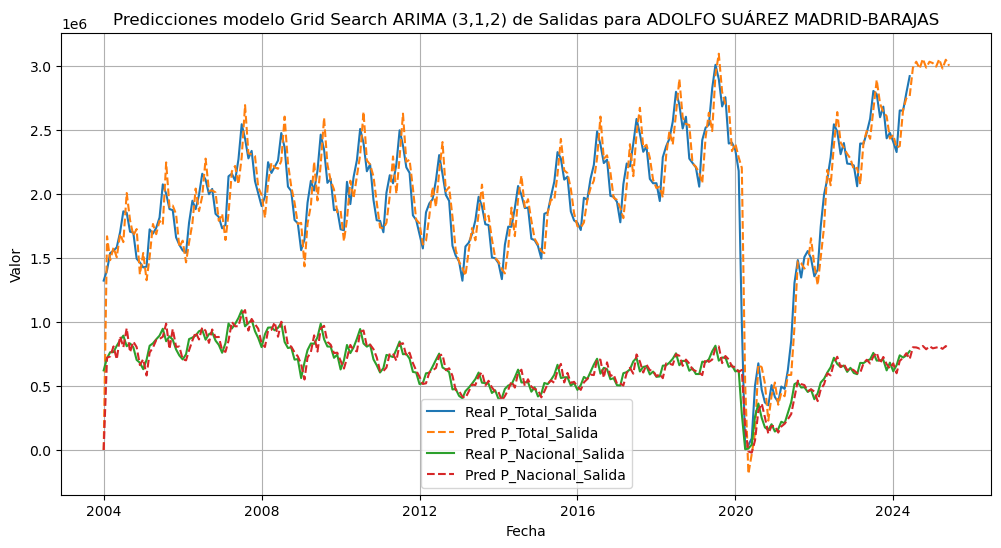

In [21]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajeros = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Pasajeros if 'Salida' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajeros_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajeros_GS = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajeros_GS = Predicciones_Pasajeros_GS[(Predicciones_Pasajeros_GS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajeros_GS['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajeros_GS.index, Datos_Reales_Pasajeros_GS['Valor'], label=f'Real {Tipo_Pasajeros_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajeros_GS['Fecha'], Datos_Predicciones_Pasajeros_GS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajeros_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (3,1,2) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**2-d. Métricas de error**

In [77]:
# Función para calcular SMAPE
def smape(y_true_GS, y_pred_GS):
    return 100 / len(y_true_GS) * np.sum(2 * np.abs(y_pred_GS - y_true_GS) / (np.abs(y_true_GS) + np.abs(y_pred_GS)))

# Se añade la métrica SMAPE
Metricas_Error_Pasajeros_GS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_GS, _, Fechas_Reales) in Dicc_Predicciones_Pasajeros_GS.items():
    # Se obtienen los valores reales
    Valores_Reales_Pasajero_GS = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Pasajero_GS) == len(Predicciones_Originales_GS):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Pasajero_GS, Predicciones_Originales_GS)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Pasajero_GS, Predicciones_Originales_GS))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Pasajero_GS - Predicciones_Originales_GS) / np.where(Valores_Reales_Pasajero_GS == 0, 1, Valores_Reales_Pasajero_GS))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Pasajero_GS, Predicciones_Originales_GS)
        
        Temp_Metricas_Error_GS = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Pasajero],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Pasajeros_GS = pd.concat([Metricas_Error_Pasajeros_GS, Temp_Metricas_Error_GS], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Pasajero}")

# Se muestran las métricas
print(Metricas_Error_Pasajeros_GS)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     P_Total_Llegada    4097.351727   
1                        A CORUÑA  P_Nacional_Llegada    3821.452540   
2                        A CORUÑA      P_Total_Salida    3242.211761   
3                        A CORUÑA   P_Nacional_Salida    3021.471360   
4    ADOLFO SUÁREZ MADRID-BARAJAS     P_Total_Llegada  117828.913064   
..                            ...                 ...            ...   
191                     SON BONET   P_Nacional_Salida      50.576086   
192              MURCIA COMBINADO     P_Total_Llegada    9732.373206   
193              MURCIA COMBINADO  P_Nacional_Llegada     626.244349   
194              MURCIA COMBINADO      P_Total_Salida    7832.848511   
195              MURCIA COMBINADO   P_Nacional_Salida     614.332891   

              RMSE         MAPE      SMAPE  
0      5448.934252    68.098511  13.435865  
1      5093.063291    65.216837  13.526843  


**2-e. Métricas de error promedias de todo el conjunto**

Se calculan los datos promedios de los errores para así, tener una visión de conjunto

In [27]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_GS = Metricas_Error_Pasajeros_GS['MAE'].mean()
RMSE_promedio_GS = Metricas_Error_Pasajeros_GS['RMSE'].mean()
MAPE_promedio_GS = Metricas_Error_Pasajeros_GS['MAPE'].mean()
SMAPE_promedio_GS = Metricas_Error_Pasajeros_GS['SMAPE'].mean()


# Se muestran los resultados GRID SEARCH ARIMA (3,1,2)
print(f"MAE Promedio GRID SEARCH ARIMA (3,1,2): {MAE_promedio_GS}")
print(f"RMSE Promedio GRID SEARCH ARIMA (3,1,2): {RMSE_promedio_GS}")
print(f"MAPE Promedio GRID SEARCH ARIMA (3,1,2): {MAPE_promedio_GS}%")
print(f"SMAPE Promedio GRID SEARCH ARIMA (3,1,2): {SMAPE_promedio_GS}%")

MAE Promedio GRID SEARCH ARIMA (3,1,2): 11668.156970912942
RMSE Promedio GRID SEARCH ARIMA (3,1,2): 16412.723248343344
MAPE Promedio GRID SEARCH ARIMA (3,1,2): 342.1325425151057%
SMAPE Promedio GRID SEARCH ARIMA (3,1,2): 29.505322260432433%


Si se observan los datos de la predicciones, los datos que se obtienen son muy similare a los originales.
El MAE ha disminuido con respecto a los datos que se tenían con ARIMA sin el Grid Search, por lo que las predicciones son más precisas, como ya se ha podido comprobar.
También el Error Cuatrático Medio, ha disminuido, por lo que se están cometiendo menos en las predicciones.
Por último, el MAPE también ha mejorado, por lo que parece que este modelo es mejor que el ARIMA sin el GRID SEARCH.
Aún así, siguen siendo valores muy altos de métricas de error

**3. Modelo Grid Search - ARIMA - 2 intento**

Se modifica el rango de los hiperparámetros para ver si se obtienen mejores resultados

In [24]:
p = d = q = range(0, 6)  # Esto probará valores de 0 a 5 para p, d, q
pdq = list(itertools.product(p, d, q))

# Se almcenan los mejores resultados
best_aic = float('inf')
best_params = None

# Se itera sobre cada combinación de parámetros
for params in pdq:
    try:
        # Se entrena el modelo ARIMA con los parámetros actuales
        model_arima = ARIMA(Datos_Reales_Pasajeros['Valor'], order=params)
        model_fit_arima = model_arima.fit()
        
        # Se calcular el AIC
        aic = model_fit_arima.aic
        
        # Si el AIC actual es mejor que el anterior, actualizar los mejores parámetros
        if aic < best_aic:
            best_aic = aic
            best_params = params
            
    except Exception as e:
        print(f"Error con los parámetros {params}: {e}")
        continue

print(f'Mejor conjunto de parámetros: {best_params} con AIC: {best_aic}')

Mejor conjunto de parámetros: (2, 5, 4) con AIC: 808.4135717890924


**3-a. Se reentrena el modelo con los parámetros obtenidos, Modelo Grid Search - ARIMA - 2 intento**

Habiendo aumentado el rango de los hiperparámetros del Grid Search de 3, a 6, se obtiene otro conjunto de mejores hiperparámetros (2,5,4)

In [25]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Pasajeros_GS2 = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Pasajeros_Unico['Aeropuerto_Base'].unique()
Tipos_Pasajeros = Pasajeros_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Pasajero in Tipos_Pasajeros:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Pasajeros_GS2 = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Pasajeros_Unico['Tipo'] == Pasajero)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Pasajeros_GS2 = Datos_Reales_Pasajeros_GS2.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_GS = ARIMA(Datos_Reales_Pasajeros_GS2['Valor'], order=(2, 5, 4))
            model_fit_arima_GS = model_arima_GS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_GS2 = model_fit_arima_GS.predict(start=Datos_Reales_Pasajeros_GS2.index[0], end=Datos_Reales_Pasajeros_GS2.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_GS2 = model_fit_arima_GS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Pasajeros_GS2[(Aeropuerto, Pasajero)] = (Predicciones_Originales_GS2, Predicciones_Futuras_GS2, Datos_Reales_Pasajeros_GS2.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Pasajero}: {e}")

Error al entrenar el modelo para CÓRDOBA, P_Total_Llegada: LU decomposition error.
Error al entrenar el modelo para LA PALMA, P_Nacional_Llegada: LU decomposition error.
Error al entrenar el modelo para MADRID-TORREJÓN, P_Total_Salida: LU decomposition error.


Como da error por no poder encontrar una solución válida para los datos, se prueba con otros hiperparámetros (2,3,3)

In [28]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Pasajeros_GS2 = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Pasajeros_Unico['Aeropuerto_Base'].unique()
Tipos_Pasajeros = Pasajeros_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Pasajero in Tipos_Pasajeros:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Pasajeros_GS2 = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Pasajeros_Unico['Tipo'] == Pasajero)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Pasajeros_GS2 = Datos_Reales_Pasajeros_GS2.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_GS = ARIMA(Datos_Reales_Pasajeros_GS2['Valor'], order=(2, 3, 3))
            model_fit_arima_GS = model_arima_GS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_GS2 = model_fit_arima_GS.predict(start=Datos_Reales_Pasajeros_GS2.index[0], end=Datos_Reales_Pasajeros_GS2.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_GS2 = model_fit_arima_GS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Pasajeros_GS2[(Aeropuerto, Pasajero)] = (Predicciones_Originales_GS2, Predicciones_Futuras_GS2, Datos_Reales_Pasajeros_GS2.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Pasajero}: {e}")

**3-b. Dataframe en el que se guardan las predicciones y los datos reales**

In [29]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_GS2 = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_GS2, Predicciones_Futuras_GS2, Fechas_Reales) in Dicc_Predicciones_Pasajeros_GS2.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Valor Real': Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor'],
        'Prediccion': Predicciones_Originales_GS2
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS2), freq='MS')
    Temp_Predicciones_Futuras_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_GS2),
        'Prediccion': Predicciones_Futuras_GS2
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_GS2 = pd.concat([Comparacion_Total_Todos_Aeropuertos_GS2, Tem_Predicciones_Historicas_GS2, Temp_Predicciones_Futuras_GS2], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_GS2.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real   Prediccion
50548  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01       1597  2568.985254
50549  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01       2942  1046.134341
50550  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01       3256  3429.079916
50551  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01       2719  3131.861117
50552  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01       3482  2736.257829
50553  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01       3413  3506.975883
50554  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01       3715  3520.944054
50555  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01       7120  3647.389798
50556  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01       None  8176.790946
50557  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01       None  8263.454463
50558  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01       None  8525.555888
50559  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01       None

In [30]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_GS2['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GS2['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_GS2['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS2['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_GS2['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GS2['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_GS2['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GS2['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_GS2.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01    1597,00    2568,99
50549  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01    2942,00    1046,13
50550  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01    3256,00    3429,08
50551  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01    2719,00    3131,86
50552  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01    3482,00    2736,26
50553  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01    3413,00    3506,98
50554  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01    3715,00    3520,94
50555  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01    7120,00    3647,39
50556  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01               8176,79
50557  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01               8263,45
50558  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01               8525,56
50559  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01               8436,38
50560  MURCI

**3-c. Visualización de las predicciones** 

In [31]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Pasajeros_GS2 = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_GS2, Predicciones_Futuras_GS2, Fechas_Reales) in Dicc_Predicciones_Pasajeros_GS2.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_GS2
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GS2), freq='MS')
    Temp_Predicciones_Futuras_GS2 = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_GS2
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Pasajeros_GS2 = pd.concat([Predicciones_Pasajeros_GS2, Tem_Predicciones_Historicas_GS2, Temp_Predicciones_Futuras_GS2], ignore_index=True)

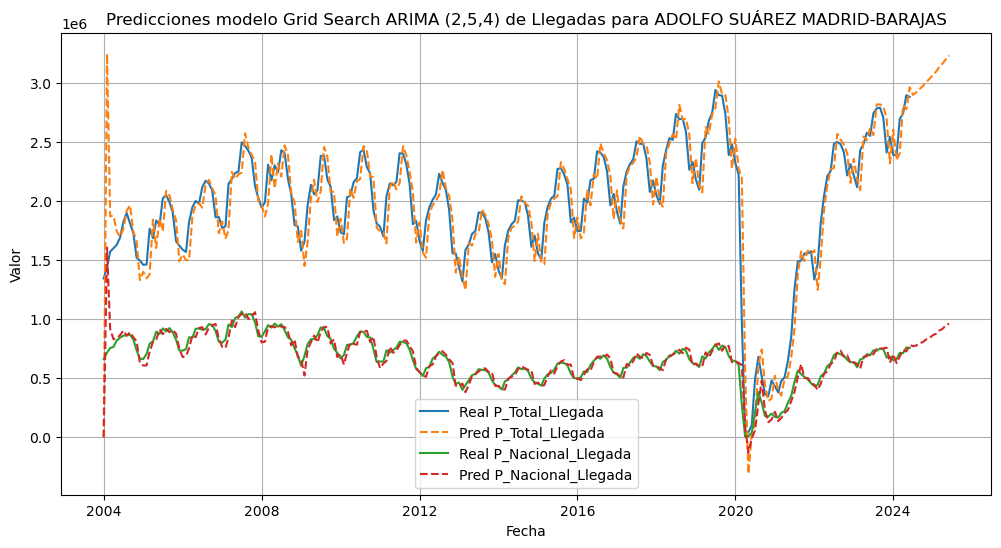

In [53]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajeros = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Pasajeros if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajeros_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajeros_GS2 = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajeros_GS2 = Predicciones_Pasajeros_GS2[(Predicciones_Pasajeros_GS2['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajeros_GS2['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajeros_GS2.index, Datos_Reales_Pasajeros_GS2['Valor'], label=f'Real {Tipo_Pasajeros_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajeros_GS2['Fecha'], Datos_Predicciones_Pasajeros_GS2['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajeros_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (2,5,4) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

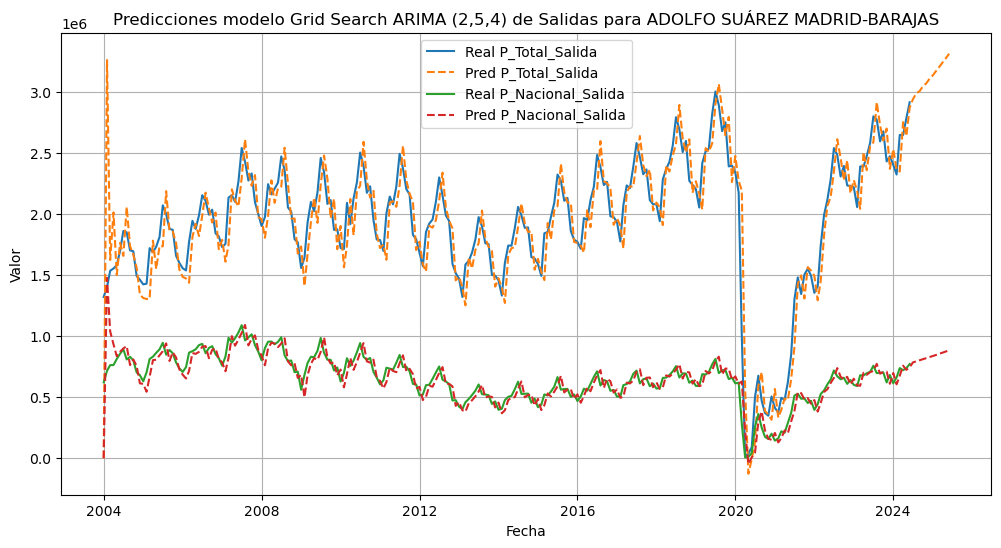

In [54]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajeros = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Pasajeros if 'Salida' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajeros_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajeros_GS2 = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajeros_GS2 = Predicciones_Pasajeros_GS2[(Predicciones_Pasajeros_GS2['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajeros_GS2['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajeros_GS2.index, Datos_Reales_Pasajeros_GS2['Valor'], label=f'Real {Tipo_Pasajeros_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajeros_GS2['Fecha'], Datos_Predicciones_Pasajeros_GS2['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajeros_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Grid Search ARIMA (2,5,4) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**3-d. Métricas de error**

In [75]:
# Función para calcular SMAPE
def smape(y_true_GS2, y_pred_GS2):
    return 100 / len(y_true_GS2) * np.sum(2 * np.abs(y_pred_GS2 - y_true_GS2) / (np.abs(y_true_GS2) + np.abs(y_pred_GS2)))

# Se añade la métrica SMAPE
Metricas_Error_Pasajeros_GS2 = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_GS2, _, Fechas_Reales) in Dicc_Predicciones_Pasajeros_GS2.items():
    # Se obtienen los valores reales
    Valores_Reales_Pasajero_GS2 = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Pasajero_GS2) == len(Predicciones_Originales_GS2):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Pasajero_GS2, Predicciones_Originales_GS2)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Pasajero_GS2, Predicciones_Originales_GS2))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Pasajero_GS2 - Predicciones_Originales_GS2) / np.where(Valores_Reales_Pasajero_GS2 == 0, 1, Valores_Reales_Pasajero_GS2))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Pasajero_GS2, Predicciones_Originales_GS2)
        
        Temp_Metricas_Error_GS2 = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Pasajero],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Pasajeros_GS2 = pd.concat([Metricas_Error_Pasajeros_GS2, Temp_Metricas_Error_GS2], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Pasajero}")

# Se muestran las métricas
print(Metricas_Error_Pasajeros_GS2)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     P_Total_Llegada    4634.465964   
1                        A CORUÑA  P_Nacional_Llegada    4340.735009   
2                        A CORUÑA      P_Total_Salida    3484.400986   
3                        A CORUÑA   P_Nacional_Salida    3295.393014   
4    ADOLFO SUÁREZ MADRID-BARAJAS     P_Total_Llegada  147520.941368   
..                            ...                 ...            ...   
191                     SON BONET   P_Nacional_Salida      52.314485   
192              MURCIA COMBINADO     P_Total_Llegada   11621.764010   
193              MURCIA COMBINADO  P_Nacional_Llegada     670.522317   
194              MURCIA COMBINADO      P_Total_Salida   10086.390954   
195              MURCIA COMBINADO   P_Nacional_Salida     655.492779   

              RMSE         MAPE      SMAPE  
0      6203.475395    55.915692  14.985485  
1      5769.373140    53.250186  15.228972  


**3-e. Métricas de error promedias de todo el conjunto**

In [36]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_GS2 = Metricas_Error_Pasajeros_GS2['MAE'].mean()
RMSE_promedio_GS2 = Metricas_Error_Pasajeros_GS2['RMSE'].mean()
MAPE_promedio_GS2 = Metricas_Error_Pasajeros_GS2['MAPE'].mean()
SMAPE_promedio_GS2 = Metricas_Error_Pasajeros_GS2['SMAPE'].mean()


# Se muestran los resultados GRID SEARCH ARIMA (2,3,3)
print(f"MAE Promedio GRID SEARCH ARIMA (2,3,3): {MAE_promedio_GS2}")
print(f"RMSE Promedio GRID SEARCH ARIMA (2,3,3): {RMSE_promedio_GS2}")
print(f"MAPE Promedio GRID SEARCH ARIMA (2,3,3): {MAPE_promedio_GS2}%")
print(f"SMAPE Promedio GRID SEARCH ARIMA (2,3,3): {SMAPE_promedio_GS2}%")

MAE Promedio GRID SEARCH ARIMA (2,3,3): 15258.67234010955
RMSE Promedio GRID SEARCH ARIMA (2,3,3): 21032.014896940054
MAPE Promedio GRID SEARCH ARIMA (2,3,3): 275.42041680288213%
SMAPE Promedio GRID SEARCH ARIMA (2,3,3): 34.587075774986175%


Si se observan los valores promedios del modelos GRID SEARCH ARIMA (2,3,3) comparado con los modelos anteriores, tanto el MAE como el RSM no han disminuido, por lo que la precisión y la predicción no mejoran con respecto a los anteriores.

**4. Modelo Random Search - ARIMA**

Se prueba otro modelo de búsqueda de los mejores parámetros esta vez, de manera aleatoria, sin comprobar todas las combinaciones posibles,Random Search, y, además como el ampliar el rango, en el modelo anterior funcionó, en este caso también se vuelve a ampliar hasta 7.

In [98]:
# Se definen los rangos de p, d, q
p = d = q = range(0, 7) 
# Se crean las combinaciones posibles de p, d, q
pdq = list(itertools.product(p, d, q))

# Se define el número de combinaciones
N_Iteraciones = 11  #

# Se selecciona el número de combinaciones e iteracciones aleatoriamente
Combinaciones_Aleatorias_RS = random.sample(pdq, N_Iteraciones)

In [99]:
# Se almcenan los mejores resultados
Mejor_aic = float('inf')
Mejor_params = None

# Se itera sobre cada combinación de parámetros
for params in Combinaciones_Aleatorias_RS:
    try:
        # Se entrena el modelo ARIMA con los parámetros actuales
        model_arima_RS = ARIMA(Datos_Reales_Pasajeros['Valor'], order=params)
        model_fit_arima_RS = model_arima_RS.fit()
        
        # Se calcula el AIC
        aic = model_fit_arima_RS.aic
        
        # Si el AIC actual es mejor que el anterior, actualizar los mejores parámetros
        if aic < Mejor_aic:
            Mejor_aic = aic
            Mejor_params = params
            
    except Exception as e:
        print(f"Error con los parámetros {params}: {e}")
        continue

print(f'Mejor conjunto de parámetros: {Mejor_params} con AIC: {Mejor_aic}')

Mejor conjunto de parámetros: (6, 1, 3) con AIC: 6114.026626250066


**4-a. Se reentrena el modelo con los parámetros obtenidos, Modelo Random Search - ARIMA**

Se reentrena el modelo con el conjunto de parámetros que el modelo ha evaluado como más óptimos (6,1,3)

In [100]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Pasajeros_RS = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Pasajeros_Unico['Aeropuerto_Base'].unique()
Tipos_Pasajeros = Pasajeros_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Pasajero in Tipos_Pasajeros:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Pasajeros_RS = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Pasajeros_Unico['Tipo'] == Pasajero)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Pasajeros_RS = Datos_Reales_Pasajeros_RS.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_RS = ARIMA(Datos_Reales_Pasajeros_RS['Valor'], order=(6, 1, 3))
            model_fit_arima_RS = model_arima_RS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_RS = model_fit_arima_RS.predict(start=Datos_Reales_Pasajeros_RS.index[0], end=Datos_Reales_Pasajeros_RS.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_RS = model_fit_arima_RS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Pasajeros_RS[(Aeropuerto, Pasajero)] = (Predicciones_Originales_RS, Predicciones_Futuras_RS, Datos_Reales_Pasajeros_RS.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Pasajero}: {e}")

Error al entrenar el modelo para SEVILLA, P_Total_Llegada: LU decomposition error.
Error al entrenar el modelo para VALENCIA, P_Nacional_Llegada: LU decomposition error.


Como da error por no poder encontrar una solución válida para los datos, se prueba con otros hiperparámetros (4,1,3)

In [102]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Pasajeros_RS = {}

# Se obtienen todos los aeropurtos y tipos únicos
Aeropuertos = Pasajeros_Unico['Aeropuerto_Base'].unique()
Tipos_Pasajeros = Pasajeros_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Pasajero in Tipos_Pasajeros:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Pasajeros_RS = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Pasajeros_Unico['Tipo'] == Pasajero)]
        
        # Se comprueba que está ordenado cronologicamente
        Datos_Reales_Pasajeros_RS = Datos_Reales_Pasajeros_RS.sort_index()

        # Se entrena el modelo ARIMA en los datos históricos
        try:
            model_arima_RS = ARIMA(Datos_Reales_Pasajeros_RS['Valor'], order=(4, 1, 3))
            model_fit_arima_RS = model_arima_RS.fit()

            # Se realizan predicciones hasta los valores que ya se tienen, junio 2024 
            Predicciones_Originales_RS = model_fit_arima_RS.predict(start=Datos_Reales_Pasajeros_RS.index[0], end=Datos_Reales_Pasajeros_RS.index[-1])

           # Se realizan predicciones para fechas de las que no se tiene valores que ya se tienen, a partir de junio 2024 
            Predicciones_Futuras_RS = model_fit_arima_RS.forecast(steps=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Pasajeros_RS[(Aeropuerto, Pasajero)] = (Predicciones_Originales_RS, Predicciones_Futuras_RS, Datos_Reales_Pasajeros_RS.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Pasajero}: {e}")

**4-b. Dataframe en el que se guardan las predicciones y los datos reales**

In [103]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_RS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_RS, Predicciones_Futuras_RS, Fechas_Reales) in Dicc_Predicciones_Pasajeros_RS.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Valor Real': Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor'],
        'Prediccion': Predicciones_Originales_RS
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_RS), freq='MS')
    Temp_Predicciones_Futuras_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_RS),
        'Prediccion': Predicciones_Futuras_RS
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_RS = pd.concat([Comparacion_Total_Todos_Aeropuertos_RS, Tem_Predicciones_Historicas_RS, Temp_Predicciones_Futuras_RS], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_RS.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real   Prediccion
50548  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01       1597  2072.454482
50549  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01       2942  2013.729872
50550  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01       3256  3865.721542
50551  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01       2719  3486.743365
50552  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01       3482  2896.046207
50553  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01       3413  3807.607991
50554  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01       3715  3404.857345
50555  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01       7120  3846.268637
50556  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01       None  7638.102178
50557  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01       None  6557.037618
50558  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01       None  5354.783420
50559  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01       None

In [104]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_RS['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_RS['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_RS['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_RS['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_RS['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_RS['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_RS['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_RS['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_RS.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01    1597,00    2072,45
50549  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01    2942,00    2013,73
50550  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01    3256,00    3865,72
50551  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01    2719,00    3486,74
50552  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01    3482,00    2896,05
50553  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01    3413,00    3807,61
50554  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01    3715,00    3404,86
50555  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01    7120,00    3846,27
50556  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01               7638,10
50557  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01               6557,04
50558  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01               5354,78
50559  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01               4746,92
50560  MURCI

**4-c. Visualización de las predicciones**

In [105]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Pasajeros_RS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_RS, Predicciones_Futuras_RS, Fechas_Reales) in Dicc_Predicciones_Pasajeros_RS.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_RS
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_RS), freq='MS')
    Temp_Predicciones_Futuras_RS = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_RS
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Pasajeros_RS = pd.concat([Predicciones_Pasajeros_RS, Tem_Predicciones_Historicas_RS, Temp_Predicciones_Futuras_RS], ignore_index=True)

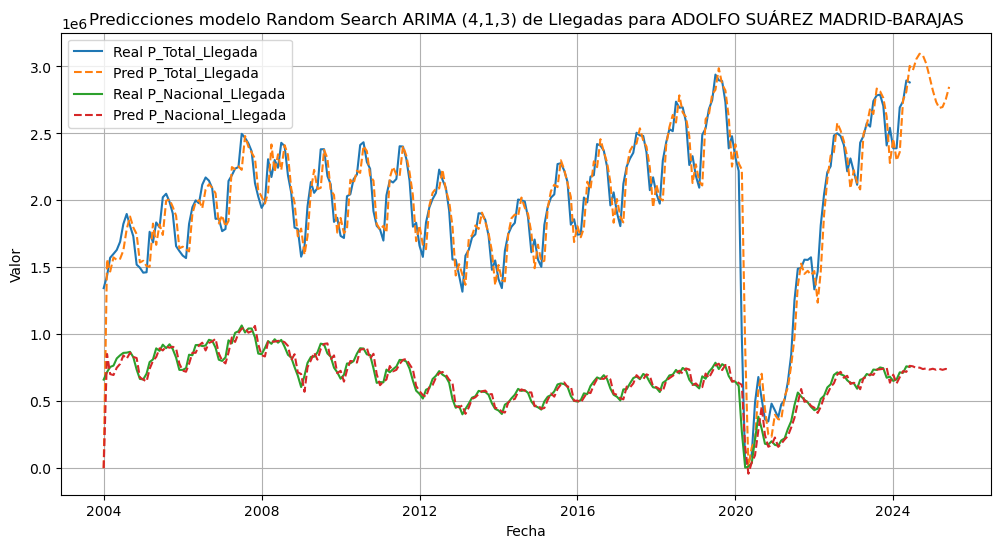

In [106]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajeros = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Pasajeros if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajeros_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajeros_RS = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajeros_RS = Predicciones_Pasajeros_GS[(Predicciones_Pasajeros_RS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajeros_RS['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajeros_RS.index, Datos_Reales_Pasajeros_RS['Valor'], label=f'Real {Tipo_Pasajeros_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajeros_RS['Fecha'], Datos_Predicciones_Pasajeros_RS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajeros_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Random Search ARIMA (4,1,3) de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

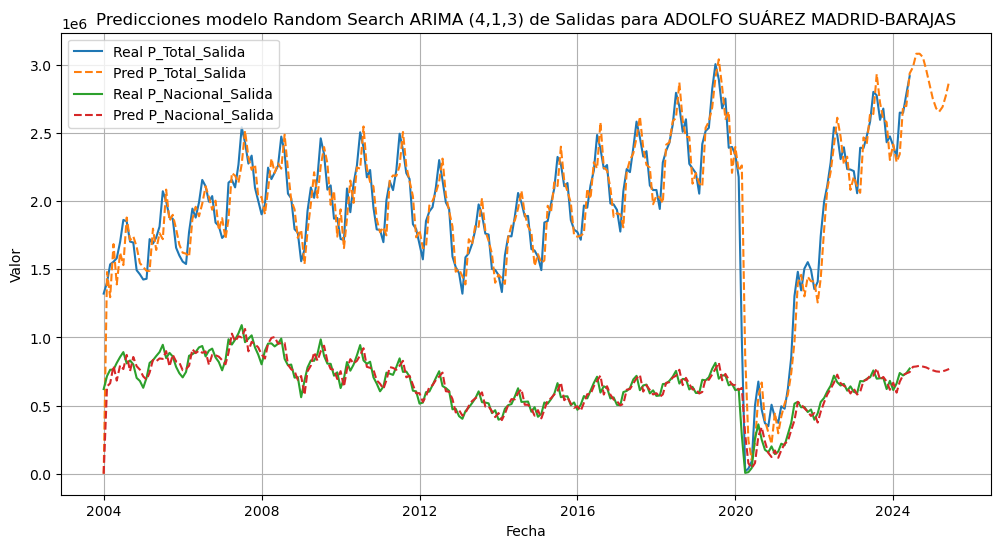

In [107]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajeros = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Pasajeros if 'Salida' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajeros_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajeros_RS = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajeros_RS = Predicciones_Pasajeros_RS[(Predicciones_Pasajeros_RS['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajeros_RS['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajeros_RS.index, Datos_Reales_Pasajeros_RS['Valor'], label=f'Real {Tipo_Pasajeros_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajeros_RS['Fecha'], Datos_Predicciones_Pasajeros_RS['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajeros_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Random Search ARIMA (4,1,3) de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**4-d. Métricas de error**

In [108]:
# Función para calcular SMAPE
def smape(y_true_RS, y_pred_RS):
    return 100 / len(y_true_RS) * np.sum(2 * np.abs(y_pred_RS - y_true_RS) / (np.abs(y_true_RS) + np.abs(y_pred_RS)))

# Se añade la métrica SMAPE
Metricas_Error_Pasajeros_RS = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_RS, _, Fechas_Reales) in Dicc_Predicciones_Pasajeros_RS.items():
    # Se obtienen los valores reales
    Valores_Reales_Pasajero_RS = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Pasajero_RS) == len(Predicciones_Originales_RS):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Pasajero_RS, Predicciones_Originales_RS)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Pasajero_RS, Predicciones_Originales_RS))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Pasajero_RS - Predicciones_Originales_RS) / np.where(Valores_Reales_Pasajero_RS == 0, 1, Valores_Reales_Pasajero_RS))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Pasajero_RS, Predicciones_Originales_RS)
        
        Temp_Metricas_Error_RS = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Pasajero],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Pasajeros_RS = pd.concat([Metricas_Error_Pasajeros_RS, Temp_Metricas_Error_RS], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Pasajero}")

# Se muestran las métricas
print(Metricas_Error_Pasajeros_RS)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     P_Total_Llegada    4102.151552   
1                        A CORUÑA  P_Nacional_Llegada    3499.940210   
2                        A CORUÑA      P_Total_Salida    3298.332889   
3                        A CORUÑA   P_Nacional_Salida    3110.371815   
4    ADOLFO SUÁREZ MADRID-BARAJAS     P_Total_Llegada  122941.713224   
..                            ...                 ...            ...   
191                     SON BONET   P_Nacional_Salida      42.783976   
192              MURCIA COMBINADO     P_Total_Llegada    6730.334577   
193              MURCIA COMBINADO  P_Nacional_Llegada     634.378214   
194              MURCIA COMBINADO      P_Total_Salida    7768.293633   
195              MURCIA COMBINADO   P_Nacional_Salida     615.615966   

              RMSE         MAPE      SMAPE  
0      5447.068606    68.274470  13.458902  
1      4713.434798    42.103462  12.902280  


**4-d. Métricas de error promedias de todo el conjunto**

In [109]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_RS = Metricas_Error_Pasajeros_RS['MAE'].mean()
RMSE_promedio_RS = Metricas_Error_Pasajeros_RS['RMSE'].mean()
MAPE_promedio_RS = Metricas_Error_Pasajeros_RS['MAPE'].mean()
SMAPE_promedio_RS = Metricas_Error_Pasajeros_RS['SMAPE'].mean()

# Se muestran los resultados RANDOM SEARCH ARIMA (4,1,3)
print(f"MAE Promedio RANDOM SEARCH ARIMA (4,1,3): {MAE_promedio_RS}")
print(f"RMSE Promedio RANDOM SEARCH ARIMA (4,1,3): {RMSE_promedio_RS}")
print(f"MAPE Promedio RANDOM SEARCH ARIMA (4,1,3): {MAPE_promedio_RS}%")
print(f"SMAPE Promedio RANDOM SEARCH ARIMA (4,1,3): {SMAPE_promedio_RS}%")

MAE Promedio RANDOM SEARCH ARIMA (4,1,3): 11329.4873222233
RMSE Promedio RANDOM SEARCH ARIMA (4,1,3): 15932.913749991849
MAPE Promedio RANDOM SEARCH ARIMA (4,1,3): 342.6820331991887%
SMAPE Promedio RANDOM SEARCH ARIMA (4,1,3): 29.273948826288517%


Este modelo ha mejorado ligeramente en medias con respecto al modelo anterior GRID SEARCH ARIMA (3,1,2) como se puede comprobar con los datos obtenidos de las métricas de errores, por ahora este modelo es el que mejor resultados de predicción ha dado.

- MAE Promedio GRID SEARCH ARIMA (3,1,2): 11668.156970912942
- RMSE Promedio GRID SEARCH ARIMA (3,1,2): 16412.723248343344
- MAPE Promedio GRID SEARCH ARIMA (3,1,2): 342.1325425151057%
- SMAPE Promedio GRID SEARCH ARIMA (3,1,2): 29.505322260432433%

**5. Modelo Exponencial Holt-Winters - aditivo**

Dado que las series presentan cierta estacionalidad se prueba con este tipo de modelo, para ver si mejoran las predicciones

In [47]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_HoltWinters_AD = {}

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Pasajeros_Unico['Aeropuerto_Base'].unique()
Tipos_Pasajeros = Pasajeros_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Pasajero in Tipos_Pasajeros:
        # Se filtra cada aeropuerto y tipo de operación
        Datos_Reales_Pasajero_HW_AD = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                      (Pasajeros_Unico['Tipo'] == Pasajero)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Pasajero_HW_AD = Datos_Reales_Pasajero_HW_AD.sort_index()

        # Se entrena el modelo Holt-Winters en los datos históricos
        try:
            model_hw_AD = ExponentialSmoothing(Datos_Reales_Pasajero_HW_AD['Valor'], 
                                            trend='add', 
                                            seasonal='add', 
                                            seasonal_periods=12)
            model_fit_hw_AD = model_hw_AD.fit()

            # Se realizan predicciones para los valores históricos
            Predicciones_Originales_HWA = model_fit_hw_AD.predict(start=Datos_Reales_Pasajero_HW_AD.index[0], end=Datos_Reales_Pasajero_HW_AD.index[-1])

            # Se realizan predicciones para fechas futuras, el siguiente año completo, 12 meses
            Predicciones_Futuras_HWA = model_fit_hw_AD.forecast(steps=12)

             # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_HoltWinters_AD[(Aeropuerto, Pasajero)] = (Predicciones_Originales_HWA, Predicciones_Futuras_HWA, Datos_Reales_Pasajero_HW_AD.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo Holt-Winters ADitivo para {Aeropuerto}, {Pasajero}: {e}")

**5-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [48]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_HWA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_HWA, Predicciones_Futuras_HWA, Fechas_Reales) in Dicc_Predicciones_HoltWinters_AD.items():
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Valor Real': Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor'],
        'Prediccion': Predicciones_Originales_HWA
    })

    # Se crea un DataFrame para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_HWA), freq='MS')
    Temp_Predicciones_Futuras_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_HWA),
        'Prediccion': Predicciones_Futuras_HWA
    })

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_HWA = pd.concat([Comparacion_Total_Todos_Aeropuertos_HWA, Tem_Predicciones_Historicas_HWA, Temp_Predicciones_Futuras_HWA], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_HWA.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real   Prediccion
50548  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01       1597  1262.606948
50549  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01       2942  2438.297539
50550  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01       3256  3073.605805
50551  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01       2719  3501.032859
50552  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01       3482  4147.541493
50553  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01       3413  4904.503769
50554  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01       3715  4317.195670
50555  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01       7120  6368.770933
50556  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01       None  8417.442595
50557  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01       None  8896.915986
50558  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01       None  6437.317239
50559  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01       None

In [49]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_HWA['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_HWA['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_HWA['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_HWA['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_HWA['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_HWA['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_HWA.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01    1597,00    1262,61
50549  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01    2942,00    2438,30
50550  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01    3256,00    3073,61
50551  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01    2719,00    3501,03
50552  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01    3482,00    4147,54
50553  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01    3413,00    4904,50
50554  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01    3715,00    4317,20
50555  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01    7120,00    6368,77
50556  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01               8417,44
50557  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01               8896,92
50558  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01               6437,32
50559  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01               2889,80
50560  MURCI

**5-b. Métricas de error**

In [110]:
# Función para calcular SMAPE
def smape(y_true_HWA, y_pred_HWA):
    return 100 / len(y_true_HWA) * np.sum(2 * np.abs(y_pred_HWA - y_true_HWA) / (np.abs(y_true_HWA) + np.abs(y_pred_HWA)))

# Se añade la métrica SMAPE
Metricas_Error_Pasajeros_HWA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_HWA, _, Fechas_Reales) in Dicc_Predicciones_HoltWinters_AD.items():
    # Se obtienen los valores reales
    Valores_Reales_Pasajero_HWA = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                       (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor']
    
    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Pasajero_HWA) == len(Predicciones_Originales_HWA):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Pasajero_HWA, Predicciones_Originales_HWA)
        # RMSE - Error Cuatrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Pasajero_HWA, Predicciones_Originales_HWA))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Pasajero_HWA - Predicciones_Originales_HWA) / np.where(Valores_Reales_Pasajero_HWA == 0, 1, Valores_Reales_Pasajero_HWA))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Pasajero_HWA, Predicciones_Originales_HWA)
        
        Temp_Metricas_Error_HWA = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Pasajero],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Pasajeros_HWA = pd.concat([Metricas_Error_Pasajeros_HWA, Temp_Metricas_Error_HWA], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Pasajero}")

# Se muestran las métricas
print(Metricas_Error_Pasajeros_HWA)

                  Aeropuerto_Base                Tipo           MAE  \
0                        A CORUÑA     P_Total_Llegada   2669.780421   
1                        A CORUÑA  P_Nacional_Llegada   2530.616077   
2                        A CORUÑA      P_Total_Salida   2664.997478   
3                        A CORUÑA   P_Nacional_Salida   2548.029714   
4    ADOLFO SUÁREZ MADRID-BARAJAS     P_Total_Llegada  70879.888858   
..                            ...                 ...           ...   
191                     SON BONET   P_Nacional_Salida     48.897218   
192              MURCIA COMBINADO     P_Total_Llegada   5469.470029   
193              MURCIA COMBINADO  P_Nacional_Llegada    627.485223   
194              MURCIA COMBINADO      P_Total_Salida   5163.765545   
195              MURCIA COMBINADO   P_Nacional_Salida    626.324120   

              RMSE         MAPE       SMAPE  
0      4436.004368    59.026110    9.877413  
1      4199.877078    61.486819    9.600326  
2      44

**5-c. Métricas de error promedias de todo el conjunto**

In [51]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_HWA = Metricas_Error_Pasajeros_HWA['MAE'].mean()
RMSE_promedio_HWA = Metricas_Error_Pasajeros_HWA['RMSE'].mean()
MAPE_promedio_HWA = Metricas_Error_Pasajeros_HWA['MAPE'].mean()
SMAPE_promedio_HWA = Metricas_Error_Pasajeros_HWA['SMAPE'].mean()

# Se muestran los resultados Holt-Winters Aditivo
print(f"MAE Promedio Holt-Winters Aditivo: {MAE_promedio_HWA}")
print(f"RMSE Promedio Holt-Winters Aditivo: {RMSE_promedio_HWA}")
print(f"MAPE Promedio Holt-Winters Aditivo: {MAPE_promedio_HWA}%")
print(f"SMAPE Promedio Holt-Winters Aditivo: {SMAPE_promedio_HWA}%")

MAE Promedio Holt-Winters Aditivo: 6899.51191260266
RMSE Promedio Holt-Winters Aditivo: 11690.240324493127
MAPE Promedio Holt-Winters Aditivo: 559.8002646957806%
SMAPE Promedio Holt-Winters Aditivo: 33.61823195729522%


Al igual que ocurrió con los datos de operaciones, este modelo es el que más ha mejorado las métricas.
Por lo que por ahora este es el mejor modelo.
Del mismo modo, no se va a probar con el multiplicativo, debido a que se conoce que hay aeropuertos para los cuales no hay datos va a haber problemas a la hora de realizar el modelo.

**6. Modelo Random Forest con Random Search**

Se prueba otro Random Forest pero esta vez con el Random Search, para obtener los hiperparámetros de manera aleatoria

In [52]:
#Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Pasajeros_RF = {}

# Función para crear variables lag
# Los lags permiten capturar patrones y dependencias en los datos pasados para mejorar la precisión de valores futuros
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se definen los posibles hiperparámetros del modelo para RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Pasajeros_Unico['Aeropuerto_Base'].unique()
Tipos_Pasajeros = Pasajeros_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Pasajero in Tipos_Pasajeros:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Pasajeros_RF = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Pasajeros_Unico['Tipo'] == Pasajero)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Pasajeros_RF = Datos_Reales_Pasajeros_RF.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_RF = crear_lags(Datos_Reales_Pasajeros_RF['Valor'], lags)
        
        # Se separa el conjunto en entrenamiento (80%) y test (20%)
        X = data_lags_RF.drop(columns=['Valor'])
        y = data_lags_RF['Valor']
        X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Se aplica RandomizedSearchCV para encontrar los mejores hiperparámetros
        try:
            model_RF = RandomForestRegressor(random_state=42)
            random_search = RandomizedSearchCV(model_RF, param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
            random_search.fit(X_train_RF, y_train_RF)

            # Se entrena el modelo con los mejores hiperparámetros encontrados
            best_rf_model = random_search.best_estimator_

            # Se realiza las predicciones sobre los datos históricos
            Predicciones_Originales_RF = best_rf_model.predict(X_test_RF)
            
            # Se realiza las predicciones futuras, pero es necesario construir las características de manera iterativa
            last_values = X_test_RF.iloc[-1].values
            Predicciones_Futuras_RF = []
            for _ in range(12):
                next_pred = best_rf_model.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_RF.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]  # Extraer el valor escalar de next_pred

            # Se convierten las predicciones futuras en un array de pandas
            Predicciones_Futuras_RF = pd.Series(Predicciones_Futuras_RF)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_Pasajeros_RF[(Aeropuerto, Pasajero)] = (Predicciones_Originales_RF, Predicciones_Futuras_RF, Datos_Reales_Pasajeros_RF.index[-len(Predicciones_Originales_RF):])
        
        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Pasajero}: {e}")

# Se muestra el mejor conjunto de parámetros
print(f"Mejor conjunto de parámetros: {random_search.best_params_}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 

**6-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [114]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_RF = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_RF, Predicciones_Futuras_RF, Fechas_Reales) in Dicc_Predicciones_Pasajeros_RF.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Pasajeros_RF = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                  (Pasajeros_Unico['Tipo'] == Pasajero)].loc[Fechas_Reales, 'Valor']
    
    # Alinear las fechas para que ambas series tengan las mismas fechas
    Fechas_Coincidentes = Valores_Reales_Pasajeros_RF.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_RF_Al = Predicciones_Originales_RF[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Pasajeros_RF_Al = Valores_Reales_Pasajeros_RF.loc[Fechas_Coincidentes]
    
    # Se comprueba que ambas longitudes coinciden
    if len(Valores_Reales_Pasajeros_RF_Al) == len(Predicciones_Originales_RF_Al):
        # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
        Tem_Predicciones_Historicas_RF = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto] * len(Fechas_Coincidentes),
            'Tipo': [Pasajero] * len(Fechas_Coincidentes),
            'Fecha': Fechas_Coincidentes,
            'Valor Real': Valores_Reales_Pasajeros_RF_Al,
            'Prediccion': Predicciones_Originales_RF_Al
        })

        # Se concatenan las predicciones históricas
        Comparacion_Total_Todos_Aeropuertos_RF = pd.concat([Comparacion_Total_Todos_Aeropuertos_RF, Tem_Predicciones_Historicas_RF], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden después de la alineación para {Aeropuerto} - {Pasajero}")

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_RF.tail(20))

       Aeropuerto_Base               Tipo      Fecha Valor Real   Prediccion
9584  MURCIA COMBINADO  P_Nacional_Salida 2022-11-01       1200  3861.880738
9585  MURCIA COMBINADO  P_Nacional_Salida 2022-12-01       1359  2312.683782
9586  MURCIA COMBINADO  P_Nacional_Salida 2023-01-01       1215  1153.627480
9587  MURCIA COMBINADO  P_Nacional_Salida 2023-02-01       1074   730.049571
9588  MURCIA COMBINADO  P_Nacional_Salida 2023-03-01       1844   772.588571
9589  MURCIA COMBINADO  P_Nacional_Salida 2023-04-01       3037  1163.479179
9590  MURCIA COMBINADO  P_Nacional_Salida 2023-05-01       2995  2303.839631
9591  MURCIA COMBINADO  P_Nacional_Salida 2023-06-01       5317  2972.076007
9592  MURCIA COMBINADO  P_Nacional_Salida 2023-07-01       6850  4234.430373
9593  MURCIA COMBINADO  P_Nacional_Salida 2023-08-01       7304  5260.630450
9594  MURCIA COMBINADO  P_Nacional_Salida 2023-09-01       6039  6837.553881
9595  MURCIA COMBINADO  P_Nacional_Salida 2023-10-01       3157  6389.905221

In [112]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_RF['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_RF['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_RF['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_RF['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_RF['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_RF['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_RF['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_RF['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_RF.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
11936  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01    1597,00    4098,80
11937  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01    2942,00    2993,35
11938  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01    3256,00    2433,31
11939  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01    2719,00    3015,82
11940  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01    3482,00    3178,05
11941  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01    3413,00    3188,38
11942  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01    3715,00    3165,36
11943  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01    7120,00    3804,63
11944  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01               3804,63
11945  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01               3843,23
11946  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01               3971,52
11947  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01               4172,27
11948  MURCI

**6-b. Métricas de error**

In [115]:
# Función para calcular SMAPE
def smape(y_true_RF, y_pred_RF):
    return 100 / len(y_true_RF) * np.sum(2 * np.abs(y_pred_RF - y_true_RF) / (np.abs(y_true_RF) + np.abs(y_pred_RF)))

# Se añade la métrica SMAPE
Metricas_Error_Pasajeros_RF = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_RF, _, Fechas_Reales) in Dicc_Predicciones_Pasajeros_RF.items():
    # Se alinean las fechas de los valores reales y predicciones
    Valores_Reales_Pasajero_RF = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                 (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor']
    Fechas_Coincidentes = Valores_Reales_Pasajero_RF.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_RF_Al = Predicciones_Originales_RF[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Pasajero_RF_Al = Valores_Reales_Pasajero_RF.loc[Fechas_Coincidentes]

    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Pasajero_RF_Al) == len(Predicciones_Originales_RF_Al):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Pasajero_RF_Al, Predicciones_Originales_RF_Al)
        # RMSE - Error Cuadrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Pasajero_RF_Al, Predicciones_Originales_RF_Al))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Pasajero_RF_Al - Predicciones_Originales_RF_Al) / np.where(Valores_Reales_Pasajero_RF_Al == 0, 1, Valores_Reales_Pasajero_RF_Al))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Pasajero_RF_Al, Predicciones_Originales_RF_Al)
        
        Temp_Metricas_Error_RF = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Pasajero],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Pasajeros_RF = pd.concat([Metricas_Error_Pasajeros_RF, Temp_Metricas_Error_RF], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Pasajero}")

# Se muestran las métricas
print(Metricas_Error_Pasajeros_RF)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     P_Total_Llegada    6187.119364   
1                        A CORUÑA  P_Nacional_Llegada    6227.476531   
2                        A CORUÑA      P_Total_Salida    5760.574510   
3                        A CORUÑA   P_Nacional_Salida    4846.276896   
4    ADOLFO SUÁREZ MADRID-BARAJAS     P_Total_Llegada  215539.312013   
..                            ...                 ...            ...   
191                     SON BONET   P_Nacional_Salida      83.484001   
192              MURCIA COMBINADO     P_Total_Llegada    9715.585238   
193              MURCIA COMBINADO  P_Nacional_Llegada    1719.643099   
194              MURCIA COMBINADO      P_Total_Salida   13342.597796   
195              MURCIA COMBINADO   P_Nacional_Salida    1673.254141   

              RMSE         MAPE      SMAPE  
0      7998.032981    69.426581  25.423695  
1      8288.150424    67.237113  26.140942  


**6-c. Métricas de error promedias de todo el conjunto**

In [116]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_RF = Metricas_Error_Pasajeros_RF['MAE'].mean()
RMSE_promedio_RF = Metricas_Error_Pasajeros_RF['RMSE'].mean()
MAPE_promedio_RF = Metricas_Error_Pasajeros_RF['MAPE'].mean()
SMAPE_promedio_RF = Metricas_Error_Pasajeros_RF['SMAPE'].mean()

# Se muestran los resultados Random Forest - random search
print(f"MAE Promedio Random Forest - random search: {MAE_promedio_RF}")
print(f"RMSE Promedio Random Forest - random search: {RMSE_promedio_RF}")
print(f"MAPE Promedio Random Forest - random search: {MAPE_promedio_RF}%")
print(f"SMAPE Promedio Random Forest - random search: {SMAPE_promedio_RF}%")

MAE Promedio Random Forest - random search: 22185.854727497117
RMSE Promedio Random Forest - random search: 27598.365779057647
MAPE Promedio Random Forest - random search: 194.37399450502062%
SMAPE Promedio Random Forest - random search: 40.455391850936145%


En términos generales, este modelo ha empeorado con respecto al anterior tanto para las métricas de MAE como RMSE, por lo que también se descarta.

**7. Modelo Autoarima**

El último modelo que se va a probar es el AutoARIMA

In [117]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_AutoARIMA = {}

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Pasajeros_Unico['Aeropuerto_Base'].unique()
Tipos_Pasajeros = Pasajeros_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Pasajero in Tipos_Pasajeros:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Pasajero_ARIMA = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                         (Pasajeros_Unico['Tipo'] == Pasajero)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Pasajero_ARIMA = Datos_Reales_Pasajero_ARIMA.sort_index()

        # Se entrena el modelo AutoARIMA
        try:
            model_auto_arima = auto_arima(Datos_Reales_Pasajero_ARIMA['Valor'], 
                                          seasonal=False, 
                                          stepwise=True, 
                                          trace=True, 
                                          error_action='ignore', 
                                          suppress_warnings=True)
            
            # Se realizan predicciones sobre los datos históricos
            Predicciones_Originales_ARIMA = model_auto_arima.predict_in_sample()
            
            # Se realizan predicciones para fechas futuras, 12 meses por ejemplo
            Predicciones_Futuras_ARIMA = model_auto_arima.predict(n_periods=12)

            # Se almacenan las predicciones en el diccionario
            Dicc_Predicciones_AutoARIMA[(Aeropuerto, Pasajero)] = (Predicciones_Originales_ARIMA, Predicciones_Futuras_ARIMA, Datos_Reales_Pasajero_ARIMA.index)
        
        except Exception as e:
            print(f"Error al entrenar el modelo AutoARIMA para {Aeropuerto}, {Pasajero}: {e}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4963.000, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5946.163, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5645.005, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4961.010, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5737.544, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4959.147, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4961.072, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4947.114, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5114.266, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4945.151, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5319.928, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4947.112, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4

**7-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [118]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_AutoARIMA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_ARIMA, Predicciones_Futuras_ARIMA, Fechas_Reales) in Dicc_Predicciones_AutoARIMA.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Pasajero_AutoARIMA = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Pasajeros_Unico['Tipo'] == Pasajero)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_ARIMA), len(Valores_Reales_Pasajero_AutoARIMA))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Pasajero] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Pasajero_AutoARIMA[:min_len],
        'Prediccion': Predicciones_Originales_ARIMA[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_AutoARIMA = Tem_Predicciones_Historicas_AutoARIMA.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_ARIMA), freq='MS')
    Temp_Predicciones_Futuras_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_ARIMA),
        'Tipo': [Pasajero] * len(Predicciones_Futuras_ARIMA),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_ARIMA),
        'Prediccion': Predicciones_Futuras_ARIMA
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_AutoARIMA = Temp_Predicciones_Futuras_AutoARIMA.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_AutoARIMA = pd.concat([Comparacion_Total_Todos_Aeropuertos_AutoARIMA, Tem_Predicciones_Historicas_AutoARIMA, Temp_Predicciones_Futuras_AutoARIMA], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_AutoARIMA.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real   Prediccion
50548  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01      1597.0  2190.795285
50549  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01      2942.0  1792.351029
50550  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01      3256.0  3988.704406
50551  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01      2719.0  3598.221731
50552  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01      3482.0  2785.685391
50553  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01      3413.0  3888.528660
50554  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01      3715.0  3412.214869
50555  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01      7120.0  3791.161328
50556  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01         NaN  7583.032681
50557  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01         NaN  6570.511858
50558  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01         NaN  5366.799784
50559  MURCIA COMBINADO  P_Nacional_Salida 2024-10-0

In [119]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_AutoARIMA['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_AutoARIMA['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_AutoARIMA['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_AutoARIMA['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_AutoARIMA['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_AutoARIMA['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_AutoARIMA['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_AutoARIMA['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_AutoARIMA.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
50548  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01    1597,00    2190,80
50549  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01    2942,00    1792,35
50550  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01    3256,00    3988,70
50551  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01    2719,00    3598,22
50552  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01    3482,00    2785,69
50553  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01    3413,00    3888,53
50554  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01    3715,00    3412,21
50555  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01    7120,00    3791,16
50556  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01               7583,03
50557  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01               6570,51
50558  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01               5366,80
50559  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01               4611,24
50560  MURCI

**7-b.Visualización de las predicciones**

In [120]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Pasajeros_AutoARIMA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_ARIMA, Predicciones_Futuras_ARIMA, Fechas_Reales) in Dicc_Predicciones_AutoARIMA.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_ARIMA
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_ARIMA), freq='MS')
    Temp_Predicciones_Futuras_AutoARIMA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_ARIMA
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Pasajeros_AutoARIMA = pd.concat([Predicciones_Pasajeros_AutoARIMA, Tem_Predicciones_Historicas_AutoARIMA, Temp_Predicciones_Futuras_AutoARIMA], ignore_index=True)

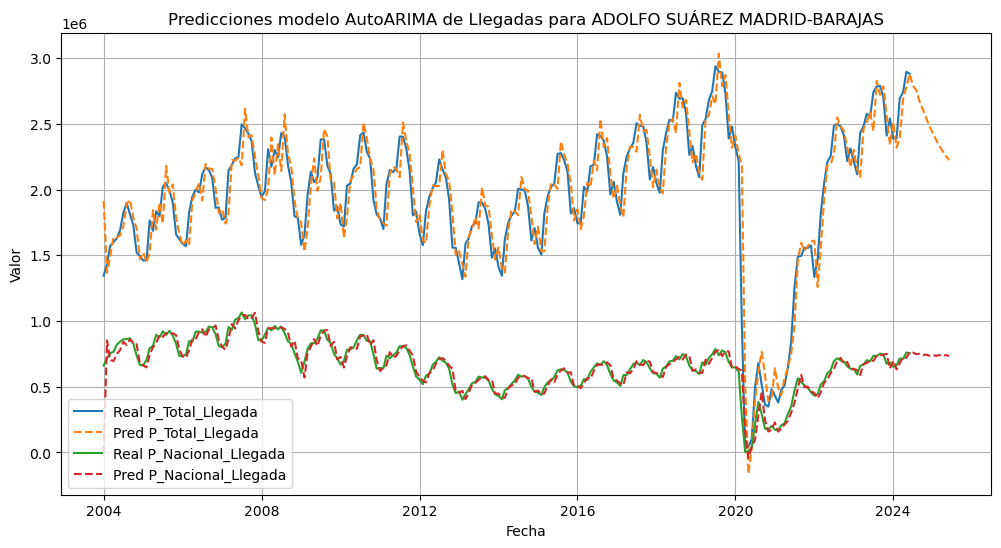

In [122]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajeros = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Pasajeros if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajeros_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajero_ARIMA = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajeros_ARIMA = Predicciones_Pasajeros_AutoARIMA[(Predicciones_Pasajeros_AutoARIMA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajeros_AutoARIMA['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajero_ARIMA.index, Datos_Reales_Pasajero_ARIMA['Valor'], label=f'Real {Tipo_Pasajeros_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajeros_ARIMA['Fecha'], Datos_Predicciones_Pasajeros_ARIMA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajeros_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo AutoARIMA de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

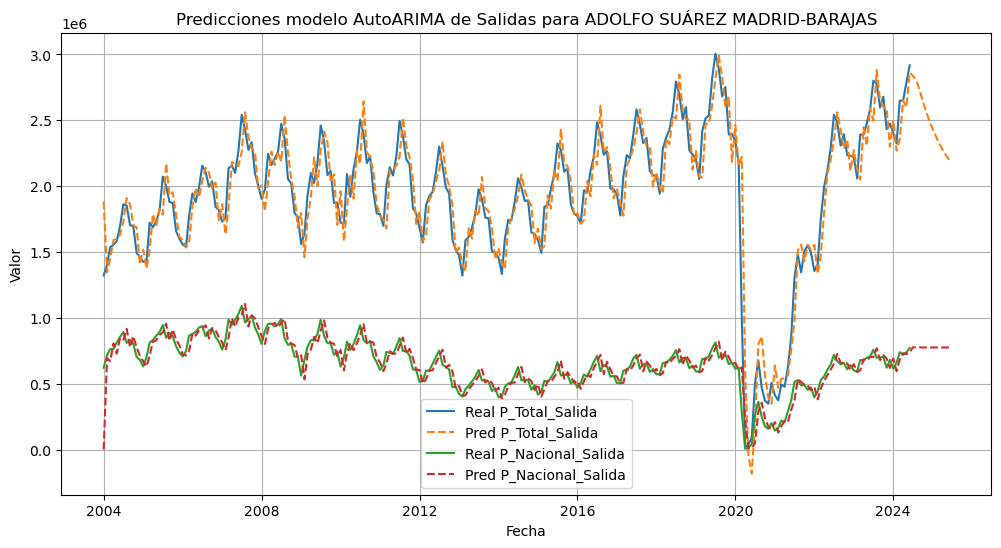

In [123]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajeros = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Pasajeros if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Pasajeros_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajero_ARIMA = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajeros_ARIMA = Predicciones_Pasajeros_AutoARIMA[(Predicciones_Pasajeros_AutoARIMA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajeros_AutoARIMA['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajero_ARIMA.index, Datos_Reales_Pasajero_ARIMA['Valor'], label=f'Real {Tipo_Pasajeros_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajeros_ARIMA['Fecha'], Datos_Predicciones_Pasajeros_ARIMA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajeros_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo AutoARIMA de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**7-c. Métricas de error**

In [125]:
# Función para calcular SMAPE
def smape(y_true_Auto, y_pred_Auto):
    return 100 / len(y_true_Auto) * np.sum(2 * np.abs(y_pred_Auto - y_true_Auto) / (np.abs(y_true_Auto) + np.abs(y_pred_Auto)))

# Se añade la métrica SMAPE
Metricas_Error_Pasajeros_Auto = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_ARIMA, _, Fechas_Reales) in Dicc_Predicciones_AutoARIMA.items():
    # Se alinean las fechas de los valores reales y predicciones
    Valores_Reales_Pasajero_AutoARIMA = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                 (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor']
    Fechas_Coincidentes = Valores_Reales_Pasajero_AutoARIMA.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_ARIMA = Predicciones_Originales_ARIMA[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Pasajero_AutoARIMA = Valores_Reales_Pasajero_AutoARIMA.loc[Fechas_Coincidentes]

    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Pasajero_AutoARIMA) == len(Predicciones_Originales_ARIMA):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Pasajero_AutoARIMA, Predicciones_Originales_ARIMA)
        # RMSE - Error Cuadrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Pasajero_AutoARIMA, Predicciones_Originales_ARIMA))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Pasajero_AutoARIMA - Predicciones_Originales_ARIMA) / np.where(Valores_Reales_Pasajero_AutoARIMA == 0, 1, Valores_Reales_Pasajero_AutoARIMA))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Pasajero_AutoARIMA, Predicciones_Originales_ARIMA)
        
        Temp_Metricas_Error_AutoARIMA = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Pasajero],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Pasajeros_Auto = pd.concat([Metricas_Error_Pasajeros_Auto, Temp_Metricas_Error_AutoARIMA], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Pasajero}")

# Se muestran las métricas
print(Metricas_Error_Pasajeros_Auto)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     P_Total_Llegada    4301.469302   
1                        A CORUÑA  P_Nacional_Llegada    3959.655917   
2                        A CORUÑA      P_Total_Salida    3275.330193   
3                        A CORUÑA   P_Nacional_Salida    3095.904678   
4    ADOLFO SUÁREZ MADRID-BARAJAS     P_Total_Llegada  122057.803122   
..                            ...                 ...            ...   
191                     SON BONET   P_Nacional_Salida      52.528455   
192              MURCIA COMBINADO     P_Total_Llegada    6993.117059   
193              MURCIA COMBINADO  P_Nacional_Llegada     612.891589   
194              MURCIA COMBINADO      P_Total_Salida    6940.324134   
195              MURCIA COMBINADO   P_Nacional_Salida     610.855824   

              RMSE         MAPE      SMAPE  
0      5647.057580    62.818168  13.266951  
1      5165.687091    62.171634  13.281195  


**7-d. Métricas de error promedias de todo el conjunto**

In [126]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_AutoARIMA = Metricas_Error_Pasajeros_Auto['MAE'].mean()
RMSE_promedio_AutoARIMA = Metricas_Error_Pasajeros_Auto['RMSE'].mean()
MAPE_promedio_AutoARIMA = Metricas_Error_Pasajeros_Auto['MAPE'].mean()
SMAPE_promedio_AutoARIMA = Metricas_Error_Pasajeros_Auto['SMAPE'].mean()

# Se muestran los resultados AutoARIMA
print(f"MAE Promedio AutoARIMA: {MAE_promedio_AutoARIMA}")
print(f"RMSE Promedio AutoARIMA: {RMSE_promedio_AutoARIMA}")
print(f"MAPE Promedio AutoARIMA): {MAPE_promedio_AutoARIMA}%")
print(f"SMAPE Promedio AutoARIMA): {SMAPE_promedio_AutoARIMA}%")

MAE Promedio AutoARIMA: 11431.408415151487
RMSE Promedio AutoARIMA: 15735.70677014524
MAPE Promedio AutoARIMA): 355.4203975032285%
SMAPE Promedio AutoARIMA): 29.715392233228297%


Al igual que ocurrió con los datos de operaciones, este modelo mejoró con respecto al RandomForest, pero si se compara con el que mejor resultado se había obtenido hasta el momento, modelo Holt-Winters Aditivo:

- MAE Promedio Holt-Winters Aditivo: 6899.51191260266
- RMSE Promedio Holt-Winters Aditivo: 11690.240324493127
- MAPE Promedio Holt-Winters Aditivo: 559.8002646957806%
- SMAPE Promedio Holt-Winters Aditivo: 33.61823195729522%

Se ve que no las métricas promedios distan considerablemente de ellas
Lo que indica que las medidas en promedio han empeorado ligeramente, respecto a las anteriores

**8. MPL Regressor**

In [6]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Pasajeros_MPL = {}

# Función para crear variables lag
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Pasajeros_Unico['Aeropuerto_Base'].unique()
Tipos_Pasajeros = Pasajeros_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Pasajero in Tipos_Pasajeros:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Pasajero_MPL = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Pasajeros_Unico['Tipo'] == Pasajero)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Pasajero_MPL = Datos_Reales_Pasajero_MPL.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_MPL = crear_lags(Datos_Reales_Pasajero_MPL['Valor'], lags)
        
        # Se Separa el conjunto en entrenamiento (70%) y test (30%)
        X = data_lags_MPL.drop(columns=['Valor'])
        y = data_lags_MPL['Valor']
        X_train_MPL, X_test_MPL, y_train_MPL, y_test_MPL = train_test_split(X, y, test_size=0.3, shuffle=False)
        
        # Entrenamiento y predicciones
        try:
            
            model_MPL = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42, max_iter=500)
            model_MPL.fit(X_train_MPL, y_train_MPL)

            # Predicciones sobre los datos históricos
            Predicciones_Originales_MPL = model_MPL.predict(X_test_MPL)

            # Predicciones futuras
            last_values = X_test_MPL.iloc[-1].values
            Predicciones_Futuras_MPL = []
            for _ in range(12):
                next_pred = model_MPL.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_MPL.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]

            Predicciones_Futuras_MPL = pd.Series(Predicciones_Futuras_MPL)

            # Almacenar las predicciones en el diccionario
            Dicc_Predicciones_Pasajeros_MPL[(Aeropuerto, Pasajero)] = (Predicciones_Originales_MPL, Predicciones_Futuras_MPL, Datos_Reales_Pasajero_MPL.index[-len(Predicciones_Originales_MPL):])

        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Pasajero}: {e}")

**8-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [7]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_MPL_O = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_MPL, Predicciones_Futuras_MPL, Fechas_Reales) in Dicc_Predicciones_Pasajeros_MPL.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Pasajero_MPL = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Pasajeros_Unico['Tipo'] == Pasajero)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_MPL), len(Valores_Reales_Pasajero_MPL))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_MPL = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Pasajero] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Pasajero_MPL[:min_len],
        'Prediccion': Predicciones_Originales_MPL[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_MPL = Tem_Predicciones_Historicas_MPL.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_MPL), freq='MS')
    Temp_Predicciones_Futuras_MPL = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_MPL),
        'Tipo': [Pasajero] * len(Predicciones_Futuras_MPL),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_MPL),
        'Prediccion': Predicciones_Futuras_MPL
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_MPL = Temp_Predicciones_Futuras_MPL.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_MPL_O = pd.concat([Comparacion_Total_Todos_Aeropuertos_MPL_O, Tem_Predicciones_Historicas_MPL, Temp_Predicciones_Futuras_MPL], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_MPL_O.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real   Prediccion
16640  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01      1597.0  5265.990445
16641  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01      2942.0  3467.263412
16642  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01      3256.0  3018.049601
16643  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01      2719.0  2696.014852
16644  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01      3482.0  3066.304629
16645  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01      3413.0  3502.600756
16646  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01      3715.0  3364.356275
16647  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01      7120.0  3821.335001
16648  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01         NaN  3821.335001
16649  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01         NaN  3810.754990
16650  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01         NaN  3889.868631
16651  MURCIA COMBINADO  P_Nacional_Salida 2024-10-0

In [8]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_MPL_O['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_MPL_O['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_MPL_O['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_MPL_O['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_MPL_O['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_MPL_O['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_MPL_O['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_MPL_O['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_MPL_O.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
16640  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01    1597,00    5265,99
16641  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01    2942,00    3467,26
16642  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01    3256,00    3018,05
16643  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01    2719,00    2696,01
16644  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01    3482,00    3066,30
16645  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01    3413,00    3502,60
16646  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01    3715,00    3364,36
16647  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01    7120,00    3821,34
16648  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01               3821,34
16649  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01               3810,75
16650  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01               3889,87
16651  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01               4101,11
16652  MURCI

**8-b.Visualización de las predicciones**

In [9]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Pasajero_MPL = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_MPL, Predicciones_Futuras_MPL, Fechas_Reales) in Dicc_Predicciones_Pasajeros_MPL.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_MPL = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_MPL
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_MPL), freq='MS')
    Temp_Predicciones_Futuras_MPL = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_MPL
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Pasajero_MPL = pd.concat([Predicciones_Pasajero_MPL, Tem_Predicciones_Historicas_MPL, Temp_Predicciones_Futuras_MPL], ignore_index=True)

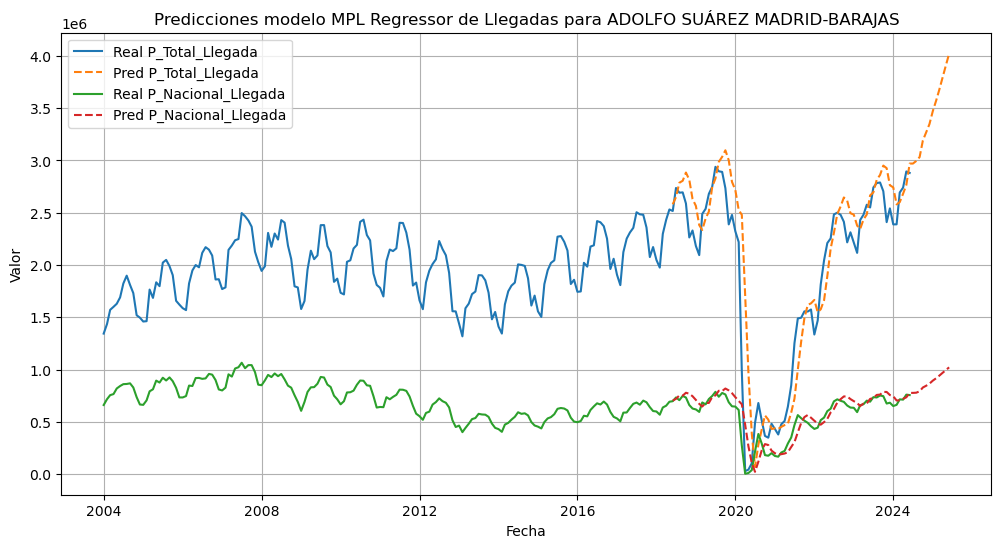

In [10]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajero = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Pasajero if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajero_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajero_MPL = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajero_MPL = Predicciones_Pasajero_MPL[(Predicciones_Pasajero_MPL['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajero_MPL['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajero_MPL.index, Datos_Reales_Pasajero_MPL['Valor'], label=f'Real {Tipo_Pasajero_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajero_MPL['Fecha'], Datos_Predicciones_Pasajero_MPL['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajero_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo MPL Regressor de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

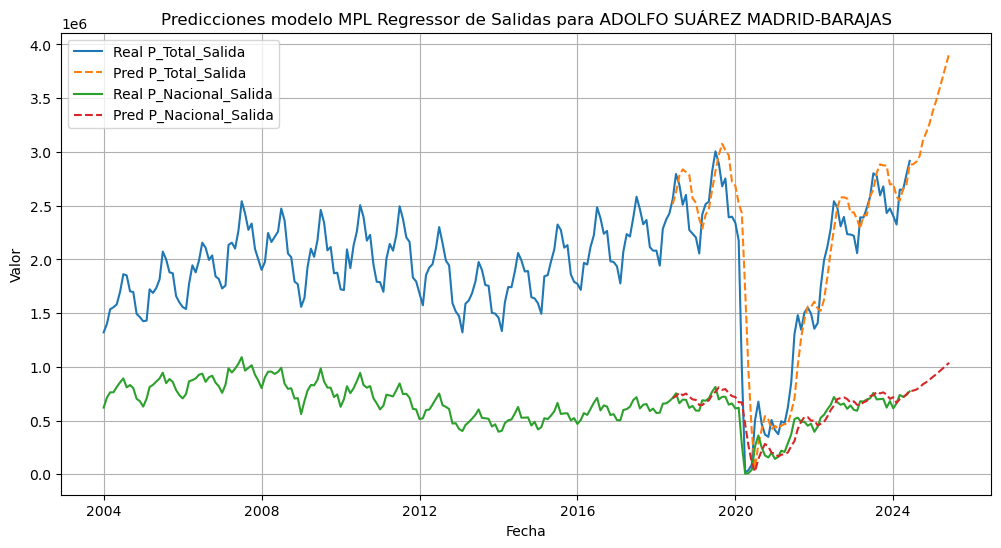

In [11]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajero = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Pasajero if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Pasajero_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajero_MPL = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajero_MPL = Predicciones_Pasajero_MPL[(Predicciones_Pasajero_MPL['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajero_MPL['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajero_MPL.index, Datos_Reales_Pasajero_MPL['Valor'], label=f'Real {Tipo_Pasajero_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajero_MPL['Fecha'], Datos_Predicciones_Pasajero_MPL['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajero_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo MPL Regressor de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**8-c. Métricas de error**

In [12]:
# Función para calcular SMAPE
def smape(y_true_MPL, y_pred_MPL):
    return 100 / len(y_true_MPL) * np.sum(2 * np.abs(y_pred_MPL - y_true_MPL) / (np.abs(y_true_MPL) + np.abs(y_pred_MPL)))

# Se añade la métrica SMAPE
Metricas_Error_Pasajeros_MPL = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_MPL, _, Fechas_Reales) in Dicc_Predicciones_Pasajeros_MPL.items():
    # Se alinean las fechas de los valores reales y predicciones
    Valores_Reales_Pasajero_MPL = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                 (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor']
    Fechas_Coincidentes = Valores_Reales_Pasajero_MPL.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_MPL = Predicciones_Originales_MPL[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Pasajero_MPL = Valores_Reales_Pasajero_MPL.loc[Fechas_Coincidentes]

    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Pasajero_MPL) == len(Predicciones_Originales_MPL):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Pasajero_MPL, Predicciones_Originales_MPL)
        # RMSE - Error Cuadrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Pasajero_MPL, Predicciones_Originales_MPL))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Pasajero_MPL - Predicciones_Originales_MPL) / np.where(Valores_Reales_Pasajero_MPL == 0, 1, Valores_Reales_Pasajero_MPL))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Pasajero_MPL, Predicciones_Originales_MPL)
        
        Temp_Metricas_Error_MPL = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Pasajero],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Pasajeros_MPL = pd.concat([Metricas_Error_Pasajeros_MPL, Temp_Metricas_Error_MPL], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Pasajero}")

# Se muestran las métricas
print(Metricas_Error_Pasajeros_MPL)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     P_Total_Llegada    6523.403130   
1                        A CORUÑA  P_Nacional_Llegada    6046.596052   
2                        A CORUÑA      P_Total_Salida    6466.739811   
3                        A CORUÑA   P_Nacional_Salida    6044.218113   
4    ADOLFO SUÁREZ MADRID-BARAJAS     P_Total_Llegada  247676.851832   
..                            ...                 ...            ...   
191                     SON BONET   P_Nacional_Salida     100.611546   
192              MURCIA COMBINADO     P_Total_Llegada    6762.838461   
193              MURCIA COMBINADO  P_Nacional_Llegada    1435.893482   
194              MURCIA COMBINADO      P_Total_Salida    6332.582512   
195              MURCIA COMBINADO   P_Nacional_Salida    1397.857884   

              RMSE         MAPE      SMAPE  
0      9195.016857   339.111001  25.921397  
1      8525.468670   329.358454  25.660543  


**8-d. Métricas de error promedias de todo el conjunto**

In [14]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_MPL = Metricas_Error_Pasajeros_MPL['MAE'].mean()
RMSE_promedio_MPL = Metricas_Error_Pasajeros_MPL['RMSE'].mean()
MAPE_promedio_MPL = Metricas_Error_Pasajeros_MPL['MAPE'].mean()
SMAPE_promedio_MPL = Metricas_Error_Pasajeros_MPL['SMAPE'].mean()

# Se muestran los resultados MPL Regressor
print(f"MAE Promedio MPL Regressor: {MAE_promedio_MPL}")
print(f"RMSE Promedio MPL Regressor: {RMSE_promedio_MPL}")
print(f"MAPE Promedio MPL Regressor: {MAPE_promedio_MPL}%")
print(f"SMAPE Promedio MPL Regressor: {SMAPE_promedio_MPL}%")

MAE Promedio MPL Regressor: 22083.125933158677
RMSE Promedio MPL Regressor: 29407.872466421595
MAPE Promedio MPL Regressor: 1255.309697710897%
SMAPE Promedio MPL Regressor: 42.012008184761505%


Con este modelo se puede comprobar que las predicciones de los datos originales se desvía bastante, está sobreestimando, por lo que para el conjunto de datos que se tiene no es un buen modelo

**9. Modelo K-Vecinos**

In [29]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Pasajeros_K = {}

# Función para crear variables lag
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Pasajeros_Unico['Aeropuerto_Base'].unique()
Tipos_Pasajeros = Pasajeros_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Pasajero in Tipos_Pasajeros:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Pasajero_K = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Pasajeros_Unico['Tipo'] == Pasajero)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Pasajero_K = Datos_Reales_Pasajero_K.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_K = crear_lags(Datos_Reales_Pasajero_K['Valor'], lags)
        
        # Se Separa el conjunto en entrenamiento (80%) y test (20%)
        X = data_lags_K.drop(columns=['Valor'])
        y = data_lags_K['Valor']
        X_train_K, X_test_K, y_train_K, y_test_K = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Entrenamiento y predicciones
        try:
            
            model_K = KNeighborsRegressor(n_neighbors=7)
            model_K.fit(X_train_K, y_train_K)

            # Predicciones sobre los datos históricos
            Predicciones_Originales_K = model_K.predict(X_test_K)

            # Predicciones futuras
            last_values = X_test_K.iloc[-1].values
            Predicciones_Futuras_K = []
            for _ in range(12):
                next_pred = model_K.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_K.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]

            Predicciones_Futuras_K = pd.Series(Predicciones_Futuras_K)

            # Almacenar las predicciones en el diccionario
            Dicc_Predicciones_Pasajeros_K[(Aeropuerto, Pasajero)] = (Predicciones_Originales_K, Predicciones_Futuras_K, Datos_Reales_Pasajero_K.index[-len(Predicciones_Originales_K):])

        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Pasajero}: {e}")

**9-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [30]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_K_P = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_K, Predicciones_Futuras_K, Fechas_Reales) in Dicc_Predicciones_Pasajeros_K.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Pasajero_K = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Pasajeros_Unico['Tipo'] == Pasajero)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_K), len(Valores_Reales_Pasajero_K))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_K = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Pasajero] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Pasajero_K[:min_len],
        'Prediccion': Predicciones_Originales_K[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_K= Tem_Predicciones_Historicas_K.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_K), freq='MS')
    Temp_Predicciones_Futuras_K= pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_K),
        'Tipo': [Pasajero] * len(Predicciones_Futuras_K),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_K),
        'Prediccion': Predicciones_Futuras_K
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_K = Temp_Predicciones_Futuras_K.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_K_P = pd.concat([Comparacion_Total_Todos_Aeropuertos_K_P, Tem_Predicciones_Historicas_K, Temp_Predicciones_Futuras_K], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_K_P.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real   Prediccion
11936  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01      1597.0  4946.428571
11937  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01      2942.0  3691.428571
11938  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01      3256.0  3070.857143
11939  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01      2719.0  2986.571429
11940  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01      3482.0  2657.142857
11941  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01      3413.0  3323.714286
11942  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01      3715.0  2647.857143
11943  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01      7120.0  3654.000000
11944  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01         NaN  3654.000000
11945  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01         NaN  3175.285714
11946  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01         NaN  2626.000000
11947  MURCIA COMBINADO  P_Nacional_Salida 2024-10-0

In [31]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_K_P['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_K_P['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_K_P['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_K_P['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_K_P['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_K_P['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_K_P['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_K_P['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_K_P.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
11936  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01    1597,00    4946,43
11937  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01    2942,00    3691,43
11938  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01    3256,00    3070,86
11939  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01    2719,00    2986,57
11940  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01    3482,00    2657,14
11941  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01    3413,00    3323,71
11942  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01    3715,00    2647,86
11943  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01    7120,00    3654,00
11944  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01               3654,00
11945  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01               3175,29
11946  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01               2626,00
11947  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01               3086,43
11948  MURCI

**9-b.Visualización de las predicciones**

In [32]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Pasajero_K = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_K, Predicciones_Futuras_K, Fechas_Reales) in Dicc_Predicciones_Pasajeros_K.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_K = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_K
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_K), freq='MS')
    Temp_Predicciones_Futuras_K = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_K
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Pasajero_K = pd.concat([Predicciones_Pasajero_K, Tem_Predicciones_Historicas_K, Temp_Predicciones_Futuras_K], ignore_index=True)

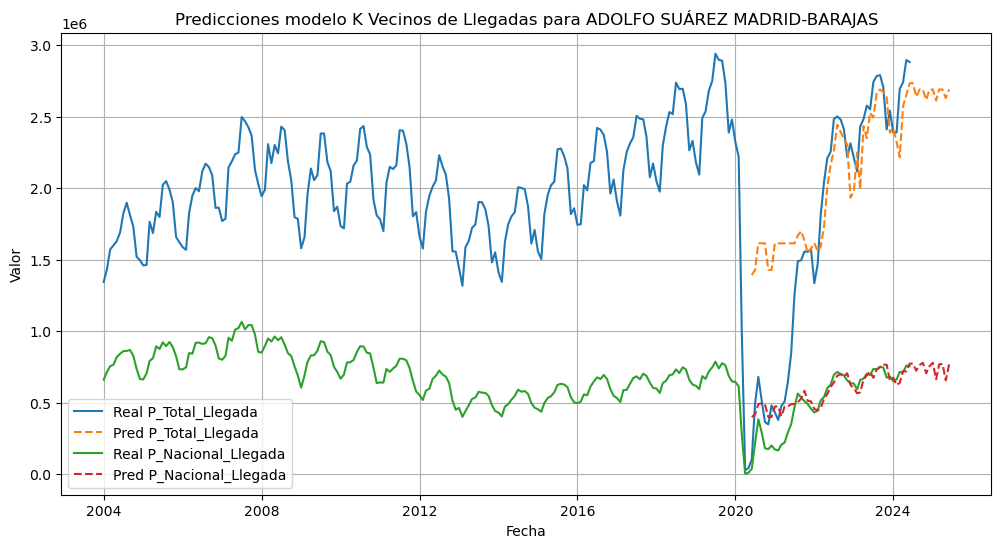

In [34]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajero = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Pasajero if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajero_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajero_K = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajero_K = Predicciones_Pasajero_K[(Predicciones_Pasajero_K['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajero_K['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajero_K.index, Datos_Reales_Pasajero_K['Valor'], label=f'Real {Tipo_Pasajero_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajero_K['Fecha'], Datos_Predicciones_Pasajero_K['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajero_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo K Vecinos de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

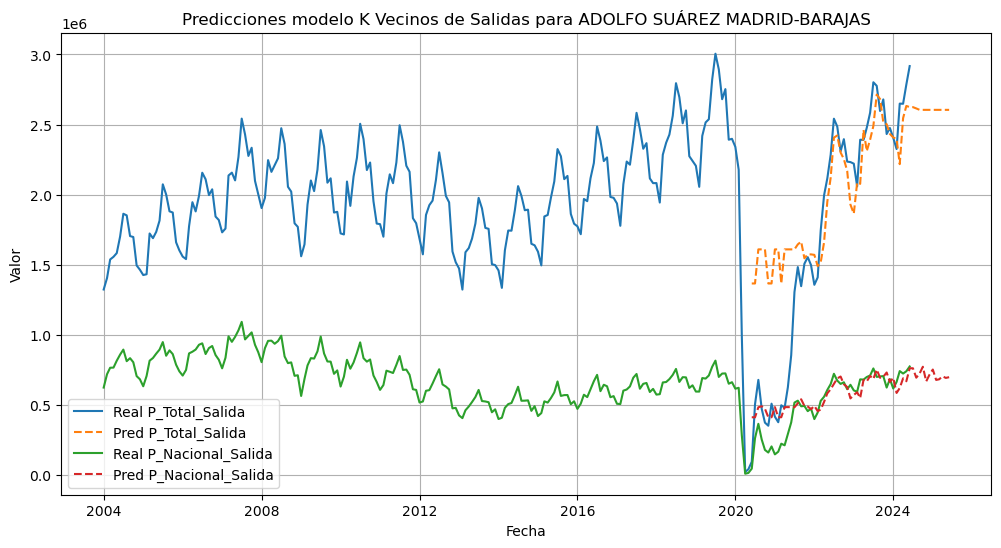

In [35]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajero = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Pasajero if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Pasajero_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajero_K = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajero_K = Predicciones_Pasajero_K[(Predicciones_Pasajero_K['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajero_K['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajero_K.index, Datos_Reales_Pasajero_K['Valor'], label=f'Real {Tipo_Pasajero_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajero_K['Fecha'], Datos_Predicciones_Pasajero_K['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajero_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo K Vecinos de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

Como se puede ver en las predicciones del aeropuerto de Murcia Combinado, las predicciones al igual que ocurría con el modelo de MPL, distan mucho de los originales, también está sobreestimando.

**10. Modelo Gradient Boosting**

In [20]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Pasajeros_GB = {}

# Función para crear variables lag
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Pasajeros_Unico['Aeropuerto_Base'].unique()
Tipos_Pasajeros = Pasajeros_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Pasajero in Tipos_Pasajeros:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Pasajero_GB = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Pasajeros_Unico['Tipo'] == Pasajero)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Pasajero_GB = Datos_Reales_Pasajero_GB.sort_index()

        # Se crean las variables lag 
        lags = 3
        data_lags_GB = crear_lags(Datos_Reales_Pasajero_GB['Valor'], lags)
        
        # Se Separa el conjunto en entrenamiento (75%) y test (25%)
        X = data_lags_GB.drop(columns=['Valor'])
        y = data_lags_GB['Valor']
        X_train_GB, X_test_GB, y_train_GB, y_test_GB = train_test_split(X, y, test_size=0.25, shuffle=False)
        
        # Entrenamiento y predicciones
        try:
            
            model_GB = GradientBoostingRegressor(n_estimators=150, random_state=42)
            model_GB.fit(X_train_GB, y_train_GB)

            # Predicciones sobre los datos históricos
            Predicciones_Originales_GB = model_GB.predict(X_test_GB)

            # Predicciones futuras
            last_values = X_test_GB.iloc[-1].values
            Predicciones_Futuras_GB = []
            for _ in range(12):
                next_pred = model_GB.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_GB.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]

            Predicciones_Futuras_GB = pd.Series(Predicciones_Futuras_GB)

            # Almacenar las predicciones en el diccionario
            Dicc_Predicciones_Pasajeros_GB[(Aeropuerto, Pasajero)] = (Predicciones_Originales_GB, Predicciones_Futuras_GB, Datos_Reales_Pasajero_GB.index[-len(Predicciones_Originales_GB):])

        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Pasajero}: {e}")

**10-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [21]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_GB_O = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_GB, Predicciones_Futuras_GB, Fechas_Reales) in Dicc_Predicciones_Pasajeros_GB.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Pasajero_GB = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Pasajeros_Unico['Tipo'] == Pasajero)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_GB), len(Valores_Reales_Pasajero_GB))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_GB = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Pasajero] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Pasajero_GB[:min_len],
        'Prediccion': Predicciones_Originales_GB[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_GB = Tem_Predicciones_Historicas_GB.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GB), freq='MS')
    Temp_Predicciones_Futuras_GB = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_GB),
        'Tipo': [Pasajero] * len(Predicciones_Futuras_GB),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_GB),
        'Prediccion': Predicciones_Futuras_GB
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_GB = Temp_Predicciones_Futuras_GB.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_GB_O = pd.concat([Comparacion_Total_Todos_Aeropuertos_GB_O, Tem_Predicciones_Historicas_GB, Temp_Predicciones_Futuras_GB], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_GB_O.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real   Prediccion
14288  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01      1597.0  3762.845096
14289  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01      2942.0  3641.076370
14290  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01      3256.0  2639.535347
14291  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01      2719.0  2934.145095
14292  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01      3482.0  3110.469521
14293  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01      3413.0  3595.732003
14294  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01      3715.0  3092.140661
14295  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01      7120.0  4179.752101
14296  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01         NaN  4179.752101
14297  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01         NaN  2963.834480
14298  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01         NaN  3211.242727
14299  MURCIA COMBINADO  P_Nacional_Salida 2024-10-0

In [22]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_GB_O['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GB_O['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_GB_O['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GB_O['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_GB_O['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_GB_O['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_GB_O['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_GB_O['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_GB_O.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
14288  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01    1597,00    3762,85
14289  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01    2942,00    3641,08
14290  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01    3256,00    2639,54
14291  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01    2719,00    2934,15
14292  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01    3482,00    3110,47
14293  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01    3413,00    3595,73
14294  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01    3715,00    3092,14
14295  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01    7120,00    4179,75
14296  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01               4179,75
14297  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01               2963,83
14298  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01               3211,24
14299  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01               5289,02
14300  MURCI

**10-b.Visualización de las predicciones**

In [23]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Pasajero_GB = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_GB, Predicciones_Futuras_GB, Fechas_Reales) in Dicc_Predicciones_Pasajeros_GB.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_GB = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_GB
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_GB), freq='MS')
    Temp_Predicciones_Futuras_GB = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_GB
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Pasajero_GB = pd.concat([Predicciones_Pasajero_GB, Tem_Predicciones_Historicas_GB, Temp_Predicciones_Futuras_GB], ignore_index=True)

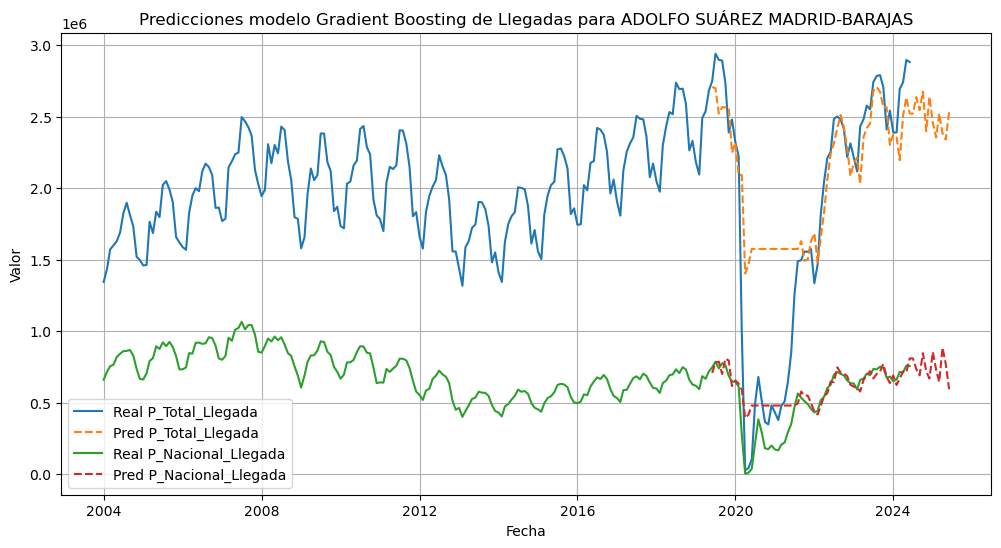

In [25]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajero = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Pasajero if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajero_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajero_GB = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajero_GB = Predicciones_Pasajero_GB[(Predicciones_Pasajero_GB['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajero_GB['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajero_GB.index, Datos_Reales_Pasajero_GB['Valor'], label=f'Real {Tipo_Pasajero_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajero_GB['Fecha'], Datos_Predicciones_Pasajero_GB['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajero_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Gradient Boosting de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

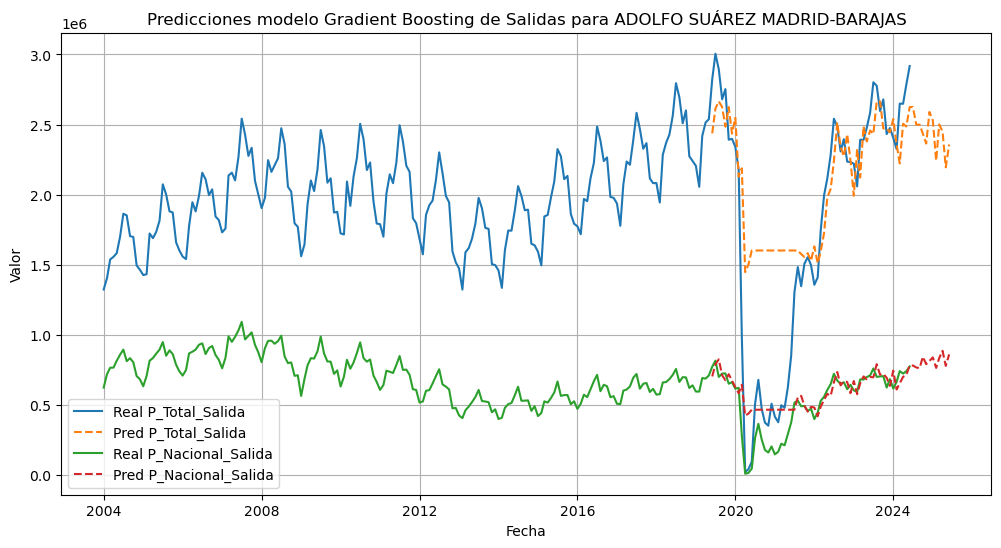

In [26]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajero = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Pasajero if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Pasajero_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajero_GB = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajero_GB = Predicciones_Pasajero_GB[(Predicciones_Pasajero_GB['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajero_GB['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajero_GB.index, Datos_Reales_Pasajero_GB['Valor'], label=f'Real {Tipo_Pasajero_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajero_GB['Fecha'], Datos_Predicciones_Pasajero_GB['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajero_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Gradient Boosting de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**10-c. Métricas de error**

In [27]:
# Función para calcular SMAPE
def smape(y_true_GB, y_pred_GB):
    return 100 / len(y_true_GB) * np.sum(2 * np.abs(y_pred_GB - y_true_GB) / (np.abs(y_true_GB) + np.abs(y_pred_GB)))

# Se añade la métrica SMAPE
Metricas_Error_Pasajeros_GB = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_GB, _, Fechas_Reales) in Dicc_Predicciones_Pasajeros_GB.items():
    # Se alinean las fechas de los valores reales y predicciones
    Valores_Reales_Pasajero_GB = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                 (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor']
    Fechas_Coincidentes = Valores_Reales_Pasajero_GB.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_GB = Predicciones_Originales_GB[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Pasajero_GB = Valores_Reales_Pasajero_GB.loc[Fechas_Coincidentes]

    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Pasajero_GB) == len(Predicciones_Originales_GB):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Pasajero_GB, Predicciones_Originales_GB)
        # RMSE - Error Cuadrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Pasajero_GB, Predicciones_Originales_GB))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Pasajero_GB - Predicciones_Originales_GB) / np.where(Valores_Reales_Pasajero_GB == 0, 1, Valores_Reales_Pasajero_GB))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Pasajero_GB, Predicciones_Originales_GB)
        
        Temp_Metricas_Error_GB = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Pasajero],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Pasajeros_GB = pd.concat([Metricas_Error_Pasajeros_GB, Temp_Metricas_Error_GB], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Pasajero}")

# Se muestran las métricas
print(Metricas_Error_Pasajeros_GB)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     P_Total_Llegada    8390.371547   
1                        A CORUÑA  P_Nacional_Llegada    7748.936836   
2                        A CORUÑA      P_Total_Salida    7750.689425   
3                        A CORUÑA   P_Nacional_Salida    6113.504410   
4    ADOLFO SUÁREZ MADRID-BARAJAS     P_Total_Llegada  411656.432711   
..                            ...                 ...            ...   
191                     SON BONET   P_Nacional_Salida     105.289830   
192              MURCIA COMBINADO     P_Total_Llegada   12069.343222   
193              MURCIA COMBINADO  P_Nacional_Llegada    1389.027375   
194              MURCIA COMBINADO      P_Total_Salida   13257.539551   
195              MURCIA COMBINADO   P_Nacional_Salida    1305.642353   

              RMSE         MAPE      SMAPE  
0     11607.270604   390.163432  33.579371  
1     10890.375171   434.965179  32.003225  


**10d. Métricas de error promedias de todo el conjunto**

In [28]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_GB = Metricas_Error_Pasajeros_GB['MAE'].mean()
RMSE_promedio_GB = Metricas_Error_Pasajeros_GB['RMSE'].mean()
MAPE_promedio_GB = Metricas_Error_Pasajeros_GB['MAPE'].mean()
SMAPE_promedio_GB = Metricas_Error_Pasajeros_GB['SMAPE'].mean()

# Se muestran los resultados Gradient Boosting
print(f"MAE Promedio Gradient Boosting: {MAE_promedio_GB}")
print(f"RMSE Promedio Gradient Boosting: {RMSE_promedio_GB}")
print(f"MAPE Promedio Gradient Boosting: {MAPE_promedio_GB}%")
print(f"SMAPE Promedio Gradient Boosting: {SMAPE_promedio_GB}%")

MAE Promedio Gradient Boosting: 26119.489309693035
RMSE Promedio Gradient Boosting: 35303.708670248765
MAPE Promedio Gradient Boosting: 1851.1019017893539%
SMAPE Promedio Gradient Boosting: 49.79789100239713%


Se puede ver tanto por los valores medios, como por las gráficas que no es un modelo que se adapte bien a los datos que tiene.

**11. Modelo Máquina de Vector Soporte**

In [70]:
# Se crea un diccionario para almacenar las predicciones
Dicc_Predicciones_Pasajeros_SVM = {}

# Función para crear variables lag
def crear_lags(data, lags):
    df_lags = pd.DataFrame()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = data.shift(lag)
    df_lags['Valor'] = data.values
    return df_lags.dropna()

# Se obtienen todos los aeropuertos y tipos únicos
Aeropuertos = Pasajeros_Unico['Aeropuerto_Base'].unique()
Tipos_Pasajeros = Pasajeros_Unico['Tipo'].unique()

# Se itera sobre cada aeropuerto y tipo
for Aeropuerto in Aeropuertos:
    for Pasajero in Tipos_Pasajeros:
        # Se filtra cada aeropuerto y tipo de operación para los datos originales "reales"
        Datos_Reales_Pasajero_SVM = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                   (Pasajeros_Unico['Tipo'] == Pasajero)]
        
        # Se comprueba que está ordenado cronológicamente
        Datos_Reales_Pasajero_SVM = Datos_Reales_Pasajero_SVM.sort_index()

        # Se crean las variables lag 
        lags = 2
        data_lags_SVM = crear_lags(Datos_Reales_Pasajero_SVM['Valor'], lags)
        
        # Se Separa el conjunto en entrenamiento (80%) y test (20%)
        X = data_lags_SVM.drop(columns=['Valor'])
        y = data_lags_SVM['Valor']
        X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Entrenamiento y predicciones
        try:
            
            model_SVM = SVR(kernel='poly', degree = 2)
            model_SVM.fit(X_train_SVM, y_train_SVM)

            # Predicciones sobre los datos históricos
            Predicciones_Originales_SVM = model_SVM.predict(X_test_SVM)

            # Predicciones futuras
            last_values = X_test_SVM.iloc[-1].values
            Predicciones_Futuras_SVM = []
            for _ in range(12):
                next_pred = model_SVM.predict(pd.DataFrame([last_values], columns=X.columns))
                Predicciones_Futuras_SVM.append(next_pred[0])
                last_values = np.roll(last_values, -1)
                last_values[-1] = next_pred[0]

            Predicciones_Futuras_SVM = pd.Series(Predicciones_Futuras_SVM)

            # Almacenar las predicciones en el diccionario
            Dicc_Predicciones_Pasajeros_SVM[(Aeropuerto, Pasajero)] = (Predicciones_Originales_SVM, Predicciones_Futuras_SVM, Datos_Reales_Pasajero_SVM.index[-len(Predicciones_Originales_SVM):])

        except Exception as e:
            print(f"Error al entrenar el modelo para {Aeropuerto}, {Pasajero}: {e}")

**11-a. Dataframe en el que se guardan las predicciones y los datos reales**

In [71]:
# Se crea un dataframe para poder comparar las predicciones
Comparacion_Total_Todos_Aeropuertos_SVM_P = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Valor Real', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_SVM, Predicciones_Futuras_SVM, Fechas_Reales) in Dicc_Predicciones_Pasajeros_SVM.items():
    # Se extraen los valores reales coincidentes con las predicciones originales
    Valores_Reales_Pasajero_SVM = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                        (Pasajeros_Unico['Tipo'] == Pasajero)].loc[Fechas_Reales, 'Valor']
    
    # Se comprueba que ambas longitudes coinciden
    min_len = min(len(Fechas_Reales), len(Predicciones_Originales_SVM), len(Valores_Reales_Pasajero_SVM))
    
    # Se crea un DataFrame temporal para las predicciones históricas con los valores originales
    Tem_Predicciones_Historicas_SVM = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * min_len,
        'Tipo': [Pasajero] * min_len,
        'Fecha': Fechas_Reales[:min_len],
        'Valor Real': Valores_Reales_Pasajero_SVM[:min_len],
        'Prediccion': Predicciones_Originales_SVM[:min_len]
    })

    # Se filtran las columnas que contenga un NaN, en el caso de las históricas, son todas aquellas que pasan de la fecha de junio 2024
    Tem_Predicciones_Historicas_SVM = Tem_Predicciones_Historicas_SVM.dropna(axis=1, how='all')

    # Se crea un DataFrame temporal para las predicciones futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_SVM), freq='MS')
    Temp_Predicciones_Futuras_SVM = pd.DataFrame({
        'Aeropuerto_Base': [Aeropuerto] * len(Predicciones_Futuras_SVM),
        'Tipo': [Pasajero] * len(Predicciones_Futuras_SVM),
        'Fecha': Fechas_Futuras,
        'Valor Real': [None] * len(Predicciones_Futuras_SVM),
        'Prediccion': Predicciones_Futuras_SVM
    })

    # Se filtran las columnas que contenga un NaN
    Temp_Predicciones_Futuras_SVM = Temp_Predicciones_Futuras_SVM.dropna(axis=1, how='all')

    # Se concatena los dos dataframe (históricos y futuros)
    Comparacion_Total_Todos_Aeropuertos_SVM_P = pd.concat([Comparacion_Total_Todos_Aeropuertos_SVM_P, Tem_Predicciones_Historicas_SVM, Temp_Predicciones_Futuras_SVM], ignore_index=True)

# Se muestran las últimas filas para ver los valores reales y predicciones
print(Comparacion_Total_Todos_Aeropuertos_SVM_P.tail(20))

        Aeropuerto_Base               Tipo      Fecha  Valor Real   Prediccion
11936  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01      1597.0  3589.794905
11937  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01      2942.0  2591.598165
11938  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01      3256.0  2563.235462
11939  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01      2719.0  2850.384313
11940  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01      3482.0  2804.894771
11941  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01      3413.0  2851.843637
11942  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01      3715.0  2997.453314
11943  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01      7120.0  3051.157616
11944  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01         NaN  3051.157616
11945  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01         NaN  2905.083696
11946  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01         NaN  2802.470915
11947  MURCIA COMBINADO  P_Nacional_Salida 2024-10-0

In [72]:
# Se convierten los valores a flotantes si no son nulos y no son cadenas vacías
Comparacion_Total_Todos_Aeropuertos_SVM_P['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_SVM_P['Valor Real'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)
Comparacion_Total_Todos_Aeropuertos_SVM_P['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_SVM_P['Prediccion'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else x)

# Se reemplazan los puntos por comas en las columnas de interés ('Valor Real' y 'Prediccion')
Comparacion_Total_Todos_Aeropuertos_SVM_P['Valor Real'] = Comparacion_Total_Todos_Aeropuertos_SVM_P['Valor Real'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')
Comparacion_Total_Todos_Aeropuertos_SVM_P['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_SVM_P['Prediccion'].apply(lambda x: f"{x:.2f}".replace('.', ',') if pd.notnull(x) else '')

# Se muestran las últimas filas para verificar los cambios
print(Comparacion_Total_Todos_Aeropuertos_SVM_P.tail(20))

        Aeropuerto_Base               Tipo      Fecha Valor Real Prediccion
11936  MURCIA COMBINADO  P_Nacional_Salida 2023-11-01    1597,00    3589,79
11937  MURCIA COMBINADO  P_Nacional_Salida 2023-12-01    2942,00    2591,60
11938  MURCIA COMBINADO  P_Nacional_Salida 2024-01-01    3256,00    2563,24
11939  MURCIA COMBINADO  P_Nacional_Salida 2024-02-01    2719,00    2850,38
11940  MURCIA COMBINADO  P_Nacional_Salida 2024-03-01    3482,00    2804,89
11941  MURCIA COMBINADO  P_Nacional_Salida 2024-04-01    3413,00    2851,84
11942  MURCIA COMBINADO  P_Nacional_Salida 2024-05-01    3715,00    2997,45
11943  MURCIA COMBINADO  P_Nacional_Salida 2024-06-01    7120,00    3051,16
11944  MURCIA COMBINADO  P_Nacional_Salida 2024-07-01               3051,16
11945  MURCIA COMBINADO  P_Nacional_Salida 2024-08-01               2905,08
11946  MURCIA COMBINADO  P_Nacional_Salida 2024-09-01               2802,47
11947  MURCIA COMBINADO  P_Nacional_Salida 2024-10-01               2755,41
11948  MURCI

**11-b.Visualización de las predicciones**

In [73]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Pasajero_SVM = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_SVM, Predicciones_Futuras_SVM, Fechas_Reales) in Dicc_Predicciones_Pasajeros_SVM.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_SVM = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_SVM
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_SVM), freq='MS')
    Temp_Predicciones_Futuras_SVM = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_SVM
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Pasajero_SVM = pd.concat([Predicciones_Pasajero_SVM, Tem_Predicciones_Historicas_SVM, Temp_Predicciones_Futuras_SVM], ignore_index=True)

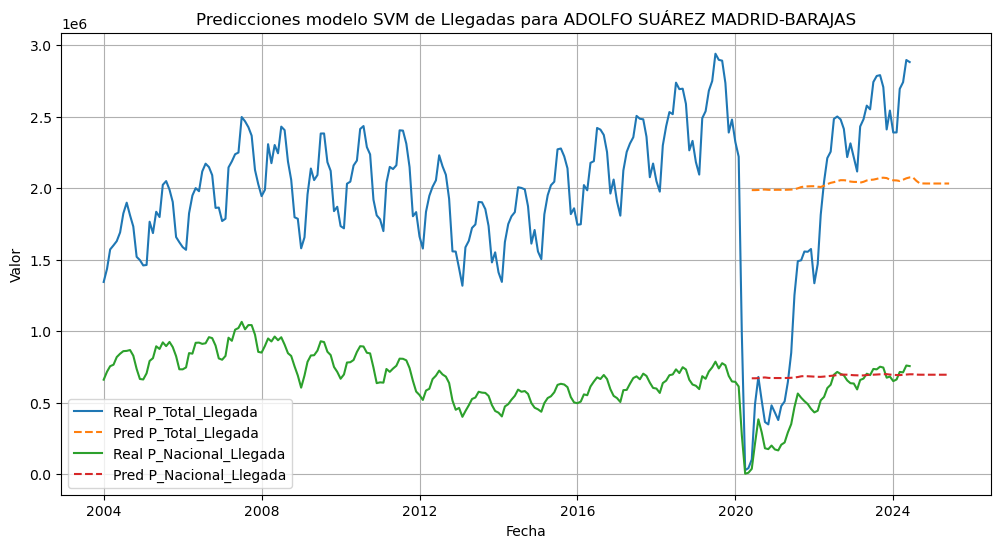

In [74]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajero = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Pasajero if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajero_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajero_SVM = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajero_SVM = Predicciones_Pasajero_SVM[(Predicciones_Pasajero_SVM['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajero_SVM['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajero_SVM.index, Datos_Reales_Pasajero_SVM['Valor'], label=f'Real {Tipo_Pasajero_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajero_SVM['Fecha'], Datos_Predicciones_Pasajero_SVM['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajero_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo SVM de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

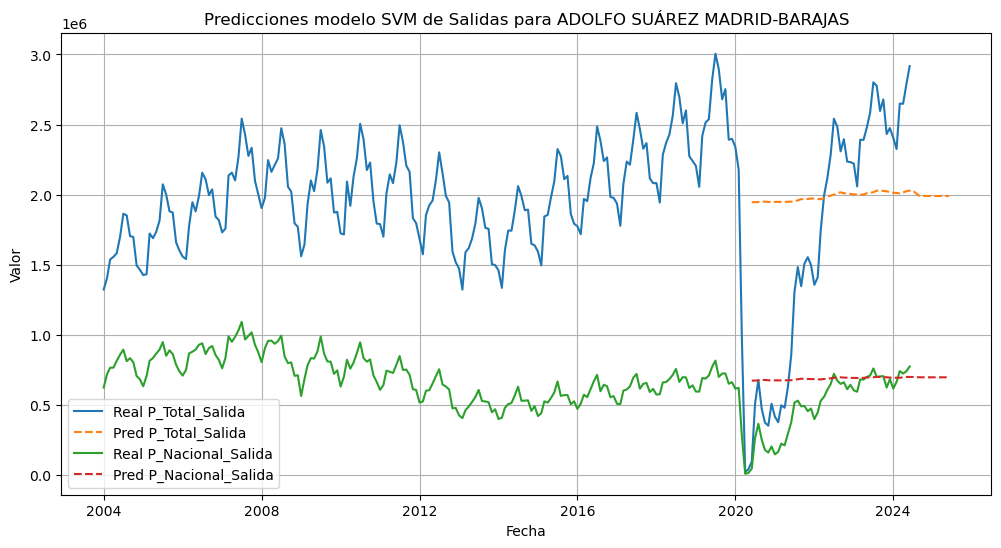

In [75]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajero = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Pasajero if 'Salida' in tipo]


# Gráfico para operaciones de Salida
plt.figure(figsize=(12, 6))
for Tipo_Pasajero_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajero_SVM = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajero_SVM = Predicciones_Pasajero_SVM[(Predicciones_Pasajero_SVM['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajero_SVM['Tipo'] == Tipo_Pasajero_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajero_SVM.index, Datos_Reales_Pasajero_SVM['Valor'], label=f'Real {Tipo_Pasajero_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajero_SVM['Fecha'], Datos_Predicciones_Pasajero_SVM['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajero_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo SVM de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**11-c. Métricas de error**

In [76]:
# Función para calcular SMAPE
def smape(y_true_SVM, y_pred_SVM):
    return 100 / len(y_true_SVM) * np.sum(2 * np.abs(y_pred_SVM - y_true_SVM) / (np.abs(y_true_SVM) + np.abs(y_pred_SVM)))

# Se añade la métrica SMAPE
Metricas_Error_Pasajeros_SVM = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'MAE', 'RMSE', 'MAPE', 'SMAPE'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_SVM, _, Fechas_Reales) in Dicc_Predicciones_Pasajeros_SVM.items():
    # Se alinean las fechas de los valores reales y predicciones
    Valores_Reales_Pasajero_SVM = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto) & 
                                                 (Pasajeros_Unico['Tipo'] == Pasajero)]['Valor']
    Fechas_Coincidentes = Valores_Reales_Pasajero_SVM.dropna().index.intersection(Fechas_Reales)
    Predicciones_Originales_SVM = Predicciones_Originales_SVM[Fechas_Reales.isin(Fechas_Coincidentes)]
    Valores_Reales_Pasajero_SVM = Valores_Reales_Pasajero_SVM.loc[Fechas_Coincidentes]

    # Se calculan las métricas de error si hay valores reales para comparar
    if len(Valores_Reales_Pasajero_SVM) == len(Predicciones_Originales_SVM):
        # MAE - Error Absoluto Medio
        mae = mean_absolute_error(Valores_Reales_Pasajero_SVM, Predicciones_Originales_SVM)
        # RMSE - Error Cuadrático Medio
        rmse = np.sqrt(mean_squared_error(Valores_Reales_Pasajero_SVM, Predicciones_Originales_SVM))
        # MAPE - Error Porcentual Absoluto Medio
        mape = np.mean(np.abs((Valores_Reales_Pasajero_SVM - Predicciones_Originales_SVM) / np.where(Valores_Reales_Pasajero_SVM == 0, 1, Valores_Reales_Pasajero_SVM))) * 100
        # SMAPE
        smape_value = smape(Valores_Reales_Pasajero_SVM, Predicciones_Originales_SVM)
        
        Temp_Metricas_Error_SVM = pd.DataFrame({
            'Aeropuerto_Base': [Aeropuerto],
            'Tipo': [Pasajero],
            'MAE': [mae],
            'RMSE': [rmse],
            'MAPE': [mape],
            'SMAPE': [smape_value]
        })
        # Se concatenan las métricas de error
        Metricas_Error_Pasajeros_SVM = pd.concat([Metricas_Error_Pasajeros_SVM, Temp_Metricas_Error_SVM], ignore_index=True)
    else:
        print(f"Las longitudes no coinciden para {Aeropuerto} - {Pasajero}")

# Se muestran las métricas
print(Metricas_Error_Pasajeros_SVM)

                  Aeropuerto_Base                Tipo            MAE  \
0                        A CORUÑA     P_Total_Llegada    8728.268646   
1                        A CORUÑA  P_Nacional_Llegada    7481.048697   
2                        A CORUÑA      P_Total_Salida    8515.429312   
3                        A CORUÑA   P_Nacional_Salida    6996.799571   
4    ADOLFO SUÁREZ MADRID-BARAJAS     P_Total_Llegada  733075.497956   
..                            ...                 ...            ...   
191                     SON BONET   P_Nacional_Salida     165.722238   
192              MURCIA COMBINADO     P_Total_Llegada   31479.373121   
193              MURCIA COMBINADO  P_Nacional_Llegada    1857.707191   
194              MURCIA COMBINADO      P_Total_Salida   32597.385794   
195              MURCIA COMBINADO   P_Nacional_Salida    1812.459008   

              RMSE         MAPE      SMAPE  
0     11567.134797    98.844112  32.191370  
1      9876.181313    86.608439  29.588674  


**11d. Métricas de error promedias de todo el conjunto**

In [77]:
# Se calculan las métricas medias para este modelo 
MAE_promedio_SVM = Metricas_Error_Pasajeros_SVM['MAE'].mean()
RMSE_promedio_SVM = Metricas_Error_Pasajeros_SVM['RMSE'].mean()
MAPE_promedio_SVM = Metricas_Error_Pasajeros_SVM['MAPE'].mean()
SMAPE_promedio_SVM = Metricas_Error_Pasajeros_SVM['SMAPE'].mean()

# Se muestran los resultados SVM
print(f"MAE Promedio SVM: {MAE_promedio_SVM}")
print(f"RMSE Promedio SVM: {RMSE_promedio_SVM}")
print(f"MAPE Promedio SVM: {MAPE_promedio_SVM}%")
print(f"SMAPE Promedio SVM: {SMAPE_promedio_SVM}%")

MAE Promedio SVM: 50016.55512798065
RMSE Promedio SVM: 59438.67573223086
MAPE Promedio SVM: 373.23077338188045%
SMAPE Promedio SVM: 57.478185760853144%


Como se puede comprobar para este modelo, las predicciones son muy malas, se ha probado a cambiar el kernel, y los parámetros asociados al modelo, pero este es el mejor resultado que se ha obtenido, y eso que es malo.

Por lo que después de haber probado 11 modelos y no conseguir que mejora, se determina que el mejor modelo al igual que ocurrió con el de operaciones, es entendible que sea el mismo modelo ya que el cuanto más número de operaciones hay, más pasajeros se mueven, por lo que van muy a la par en cuanto a comportamiento.
Modelo ganador:  **modelo de Holt-Winters Aditivo**

### C. Visualizar mejor modelo

In [128]:
# Se crea un DataFrame para almacenar todas las predicciones
Predicciones_Pasajeros_HWA = pd.DataFrame(columns=['Aeropuerto_Base', 'Tipo', 'Fecha', 'Prediccion'])

for (Aeropuerto, Pasajero), (Predicciones_Originales_HWA, Predicciones_Futuras_HWA, Fechas_Reales) in Dicc_Predicciones_HoltWinters_AD.items():
    # Se guardan en un DataFrame temporal para las predicciones de los datos orginales "reales"
    Tem_Predicciones_Historicas_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Reales,
        'Prediccion': Predicciones_Originales_HWA
    })

    # Se guardan en un DataFrame temporal para las predicciones de fechas futuras
    Fechas_Futuras = pd.date_range(start=Fechas_Reales[-1] + pd.offsets.MonthBegin(1), periods=len(Predicciones_Futuras_HWA), freq='MS')
    Temp_Predicciones_Futuras_HWA = pd.DataFrame({
        'Aeropuerto_Base': Aeropuerto,
        'Tipo': Pasajero,
        'Fecha': Fechas_Futuras,
        'Prediccion': Predicciones_Futuras_HWA
    })

    # Se concatenan ambas predicciones y se guardan en un dataframe único
    Predicciones_Pasajeros_HWA = pd.concat([Predicciones_Pasajeros_HWA, Tem_Predicciones_Historicas_HWA, Temp_Predicciones_Futuras_HWA], ignore_index=True)

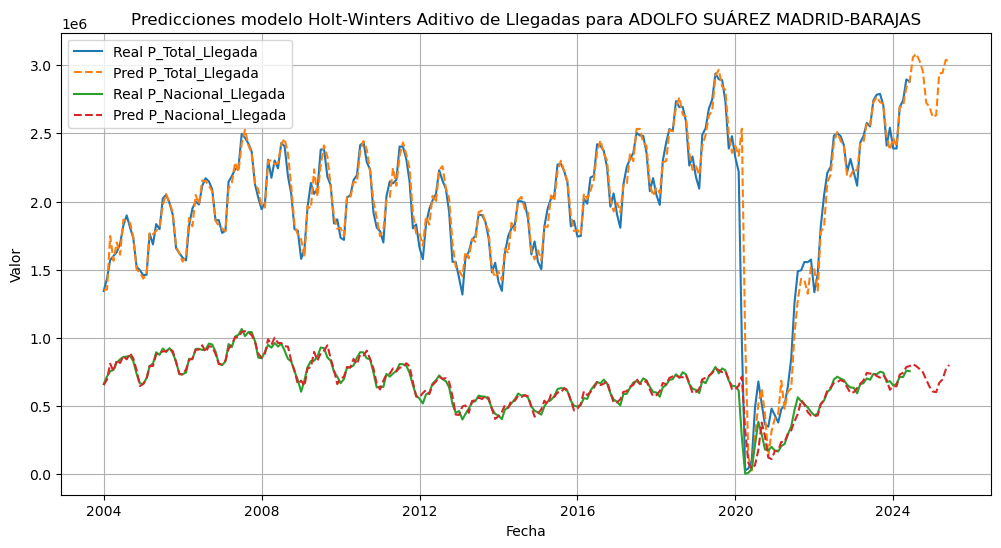

In [129]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajeros = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Llegada
Tipos_Llegada = [tipo for tipo in Tipos_Pasajeros if 'Llegada' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajeros_Prediccion in Tipos_Llegada:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajero_HWA = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajeros_HWA = Predicciones_Pasajeros_HWA[(Predicciones_Pasajeros_HWA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajeros_HWA['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajero_HWA.index, Datos_Reales_Pasajero_HWA['Valor'], label=f'Real {Tipo_Pasajeros_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajeros_HWA['Fecha'], Datos_Predicciones_Pasajeros_HWA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajeros_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Holt-Winters Aditivo de Llegadas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

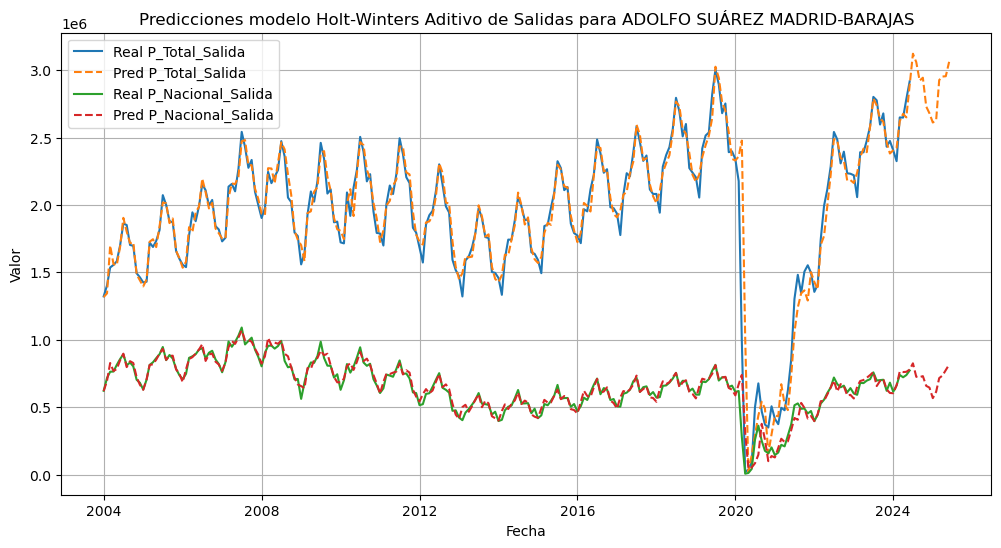

In [130]:
# Se visualizan las predicciones para un aeropuerto específico
Aeropuerto_Prediccion = 'ADOLFO SUÁREZ MADRID-BARAJAS'

# Se filtran los tipos de operación disponibles para el aeropuerto seleccionado
Tipos_Pasajeros = Pasajeros_Unico[Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion]['Tipo'].unique()

# Se filtran los tipos de operación para Salida
Tipos_Salida = [tipo for tipo in Tipos_Pasajeros if 'Salida' in tipo]


# Gráfico para operaciones de Llegada
plt.figure(figsize=(12, 6))
for Tipo_Pasajeros_Prediccion in Tipos_Salida:
    # Se filtran los datos reales para el tipo de operación
    Datos_Reales_Pasajero_HWA = Pasajeros_Unico[(Pasajeros_Unico['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                               (Pasajeros_Unico['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se filtran las predicciones para el tipo de operación
    Datos_Predicciones_Pasajeros_HWA = Predicciones_Pasajeros_HWA[(Predicciones_Pasajeros_HWA['Aeropuerto_Base'] == Aeropuerto_Prediccion) & 
                                                            (Predicciones_Pasajeros_HWA['Tipo'] == Tipo_Pasajeros_Prediccion)]
    
    # Se añaden las series reales y predicciones al gráfico
    plt.plot(Datos_Reales_Pasajero_HWA.index, Datos_Reales_Pasajero_HWA['Valor'], label=f'Real {Tipo_Pasajeros_Prediccion}')
    plt.plot(Datos_Predicciones_Pasajeros_HWA['Fecha'], Datos_Predicciones_Pasajeros_HWA['Prediccion'], linestyle='--', label=f'Pred {Tipo_Pasajeros_Prediccion}')

# Se configura el gráfico
plt.title(f'Predicciones modelo Holt-Winters Aditivo de Salidas para {Aeropuerto_Prediccion}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

### D. Guardar mejor modelo

In [132]:
# Se guardan los parámetros del modelo para cada aeropuerto
for (Aeropuerto, Pasajero), model_fit_hw_AD in Dicc_Predicciones_HoltWinters_AD.items():
    # Se limpian los nombres de archivos para que sean válidos
    nombre_aeropuerto = re.sub(r'[^\w\s]', '_', Aeropuerto)  # Reemplaza caracteres no alfanuméricos con guion bajo
    nombre_pasajero = re.sub(r'[^\w\s]', '_', Pasajero)
    
    # Se guarda el modelo usando joblib
    try:
        joblib.dump(model_fit_hw_AD, f'modelo_holt_winters_{nombre_aeropuerto}_{nombre_pasajero}.pkl')
    except Exception as e:
        print(f"Error al guardar el modelo para {Aeropuerto}, {Pasajero}: {e}")

### E. Guardar predicciones

In [133]:
# Se especifica la ruta en la que se van a guardar el dataframe
Ruta_Pasajeros_Prediccion = './Ficheros_Predicciones'

# Se crea la carpeta en la que se van a guardar, si esta no existe
if not os.path.exists(Ruta_Pasajeros_Prediccion):
    # Si la carpeta no existe, se crea
    os.makedirs(Ruta_Pasajeros_Prediccion)
    print(f"Carpeta creada: {Ruta_Pasajeros_Prediccion}")
else:
    # Si la carpeta ya existe, se muestra un mensaje
    print(f"La carpeta ya existe: {Ruta_Pasajeros_Prediccion}")

La carpeta ya existe: ./Ficheros_Predicciones


In [136]:
# Ruta para guardar las predicciones
Ruta_Operaciones_Prediccion = './Ficheros_Predicciones/Predicciones_Pasajeros.csv'

# Se reemplazan las comas por puntos en la columna 'Prediccion'
Comparacion_Total_Todos_Aeropuertos_HWA['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA['Prediccion'].str.replace(',', '.')

# Se convierte la columna 'Prediccion' a float
Comparacion_Total_Todos_Aeropuertos_HWA['Prediccion'] = Comparacion_Total_Todos_Aeropuertos_HWA['Prediccion'].astype(float)

# Se guarda el DataFrame en un archivo CSV con el formato correcto para los flotantes
Comparacion_Total_Todos_Aeropuertos_HWA.to_csv(Ruta_Pasajeros_Prediccion, index=False, encoding='utf-8', decimal=',')

print(f"Predicciones de operaciones guardadas en: {Ruta_Pasajeros_Prediccion}")

Predicciones de operaciones guardadas en: ./Ficheros_Predicciones/Predicciones_Pasajeros.csv
